In [ ]:
!pip install ultralytics

import os
import shutil
import json
import random
from IPython.display import clear_output, Image
import glob
import ast
import cv2

clear_output()

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.9/112.6 GB disk)


In [ ]:
!nvidia-smi

Tue Aug 12 12:23:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Connet to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Constants
IMAGE_WIDTH: int = 1000
IMAGE_HEIGHT: int = 800
dataset_dir: str = '/content/cataract_dataset_segmentation'
zip_file_path: str = '/content/drive/MyDrive/Datasets/insegcat-1-v2.zip'

## Preproccess Dataset

In [ ]:
class PreprocessData():
    def __init__(self, dataset_dir, zip_file_path):
        self.dataset_dir = dataset_dir
        self.zip_file_path = zip_file_path
        self.images_dir = ""
        self.labels_dir = ""

    # Dataset directory and zip file path to be extracted
    def extract_dataset(self):
        if not os.path.exists(self.zip_file_path):
            print("File not found in Google Drive path.")
        else:
            os.makedirs(self.dataset_dir, exist_ok=True)
            !unzip -q "{self.zip_file_path}" -d "{self.dataset_dir}"
            print("File opened successfully")

    # move images in the dataset_dir/images
    def organize_images(self):
        images_dir = os.path.join(self.dataset_dir, 'images')
        self.images_dir = images_dir
        os.makedirs(images_dir, exist_ok=True)

        for filename in os.listdir(self.dataset_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                shutil.move(os.path.join(self.dataset_dir, filename), os.path.join(images_dir, filename))
        print("All images moved into 'images' folder.")

    # COCO JSON preprocess
    def map_categories(self, json_file: str):
        json_file = os.path.join(self.dataset_dir, json_file)

        with open(json_file, 'r') as f:
            coco_data = json.load(f)

        categories_coco = coco_data['categories']
        cat_ids = [cat['id'] for cat in categories_coco]
        cat_names = [cat['name'] for cat in categories_coco]
        self.cat_names = cat_names
        cat_id_to_yolo = {cat_id: idx for idx, cat_id in enumerate(cat_ids)}

        print("Categories mapping:")
        for cat_id, name in zip(cat_ids, cat_names):
            print(f"COCO id {cat_id} → YOLO id {cat_id_to_yolo[cat_id]} → name '{name}'")

        return cat_id_to_yolo

    # Convert coco to yolo format and for object detection
    def convert_coco_to_yolo(self, coco_json_path, output, cat_id_to_yolo_map):
        self.labels_dir = output

        if os.path.exists(self.labels_dir):
            shutil.rmtree(self.labels_dir)
            print(f"Deleted existing folder: {self.labels_dir}")
        os.makedirs(self.labels_dir)

        with open(coco_json_path, 'r') as f:
            coco_data = json.load(f)

        images_info = {
            img['id']: {'width': img['width'], 'height': img['height'], 'file_name': img['file_name']}
            for img in coco_data['images']
        }

        for annotation in coco_data['annotations']:
            image_id = annotation['image_id']
            category_id = cat_id_to_yolo_map[annotation['category_id']]

            # mapping = {
            #     "i1": "slit knife",
            #     "i2": "angled incision knife",
            #     "i3": "katena forceps",
            #     "i7": "27 gauge cannula",
            #     "i8": "capsulorhexis forceps",
            #     "i9": "cannula",
            #     "i10": "phaco tip",
            #     "i11": "spatula",
            #     "i12": "I/A handpiece",
            #     "i16": "cartridge",
            #     "i20": "eye retractors"
            # }

            # category_id = mapping[category_id]

            if image_id not in images_info:
                continue

            img_info = images_info[image_id]
            w, h = img_info['width'], img_info['height']
            img_file_name = img_info['file_name']

            xmin, ymin, bbox_w, bbox_h = annotation['bbox']
            x_center = (xmin + bbox_w / 2) / w
            y_center = (ymin + bbox_h / 2) / h
            norm_w = bbox_w / w
            norm_h = bbox_h / h

            yolo_line = f"{category_id} {x_center} {y_center} {norm_w} {norm_h}\n"

            txt_file_path = os.path.join(self.labels_dir, os.path.splitext(img_file_name)[0] + '.txt')
            with open(txt_file_path, 'a') as f:
                f.write(yolo_line)

        print("COCO to YOLO conversion completed.")

    # Counts the number of files in a given directory using os.scandir().
    def count_files_os_scandir(self, directory_path):
        count = 0
        try:
            for entry in os.scandir(directory_path):
                if entry.is_file():
                    count += 1
            return count
        except FileNotFoundError:
            print(f"Error: Directory not found at '{directory_path}'")
            return -1
        except Exception as e:
            print(f"An error occurred: {e}")
            return -1

    # Splitting data to train, test and validation sets
    def spilt_dataset(self):
        random.seed(42)
        all_images = [f for f in os.listdir(self.images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(all_images)

        total_files = len(all_images)
        train_split_count = int(total_files * 0.8)
        val_split_count = int(total_files * 0.1)

        train_files = all_images[:train_split_count]
        val_files = all_images[train_split_count:train_split_count + val_split_count]
        test_files = all_images[train_split_count + val_split_count:]

        for split in ['train', 'val', 'test']:
            os.makedirs(os.path.join(self.dataset_dir, 'images', split), exist_ok=True)
            os.makedirs(os.path.join(self.dataset_dir, 'labels', split), exist_ok=True)

        print("Dataset split completed!")
        return train_files, val_files, test_files

    # Moving images to the related folders
    def move_files(self, file_list, split):
        for file_name in file_list:
            # image
            src_img = os.path.join(self.images_dir, file_name)
            dst_img = os.path.join(self.dataset_dir, 'images', split, file_name)
            if os.path.exists(src_img):
                shutil.move(src_img, dst_img)

            # label
            label_name = os.path.splitext(file_name)[0] + '.txt'
            src_lbl = os.path.join(self.labels_dir, label_name)
            dst_lbl = os.path.join(self.dataset_dir, 'labels', split, label_name)
            if os.path.exists(src_lbl):
                shutil.move(src_lbl, dst_lbl)

        print(f"images moved to {split} folder")

    # Create data.yaml file
    def create_yaml_file(self):
        yaml_content = f"""
        path: {self.dataset_dir}

        train: images/train
        val: images/val
        test: images/test

        nc: {len(self.cat_names)}
        names: {self.cat_names}
        """
        with open(os.path.join(self.dataset_dir, 'data.yaml'), 'w') as f:
            f.write(yaml_content)

        print("data.yaml created successfully!")

In [ ]:
preprocess = PreprocessData(dataset_dir, zip_file_path)
preprocess.extract_dataset()

File opened successfully


In [ ]:
preprocess.organize_images()

All images moved into 'images' folder.


In [ ]:
json_file = os.path.join(dataset_dir, 'coco-annotations.json')
cat_id_to_yolo = preprocess.map_categories(json_file)

labels_dir = os.path.join(dataset_dir, 'labels')
preprocess.convert_coco_to_yolo(json_file, labels_dir, cat_id_to_yolo)

Categories mapping:
COCO id 1 → YOLO id 0 → name 'i1'
COCO id 2 → YOLO id 1 → name 'i2'
COCO id 3 → YOLO id 2 → name 'i3'
COCO id 4 → YOLO id 3 → name 'i7'
COCO id 5 → YOLO id 4 → name 'i8'
COCO id 6 → YOLO id 5 → name 'i9'
COCO id 7 → YOLO id 6 → name 'i10'
COCO id 8 → YOLO id 7 → name 'i11'
COCO id 9 → YOLO id 8 → name 'i12'
COCO id 10 → YOLO id 9 → name 'i16'
COCO id 13 → YOLO id 10 → name 'i20'
COCO to YOLO conversion completed.


In [ ]:
directory = [dataset_dir + "/images", labels_dir]
for d in directory:
  num_files = preprocess.count_files_os_scandir(d)
  if num_files != -1:
      print(f"Number of files in '{d}': {num_files}")

Number of files in '/content/cataract_dataset_segmentation/images': 843
Number of files in '/content/cataract_dataset_segmentation/labels': 843


In [ ]:
train_files, val_files, test_files = preprocess.spilt_dataset()
preprocess.move_files(train_files, 'train')
preprocess.move_files(val_files, 'val')
preprocess.move_files(test_files, 'test')

Dataset split completed!
images moved to train folder
images moved to val folder
images moved to test folder


In [ ]:
preprocess.create_yaml_file()

data.yaml created successfully!


## First Model

###  Custom Training

In [ ]:
!yolo task=detect mode=train \
    data=/content/cataract_dataset_segmentation/data.yaml \
    model=yolov8n.pt \
    epochs=100 \
    imgsz=640 \
    batch=16 \
    plots=True

Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/cataract_dataset_segmentation/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, 

In [ ]:
HOME = os.getcwd()
print(HOME)

/content


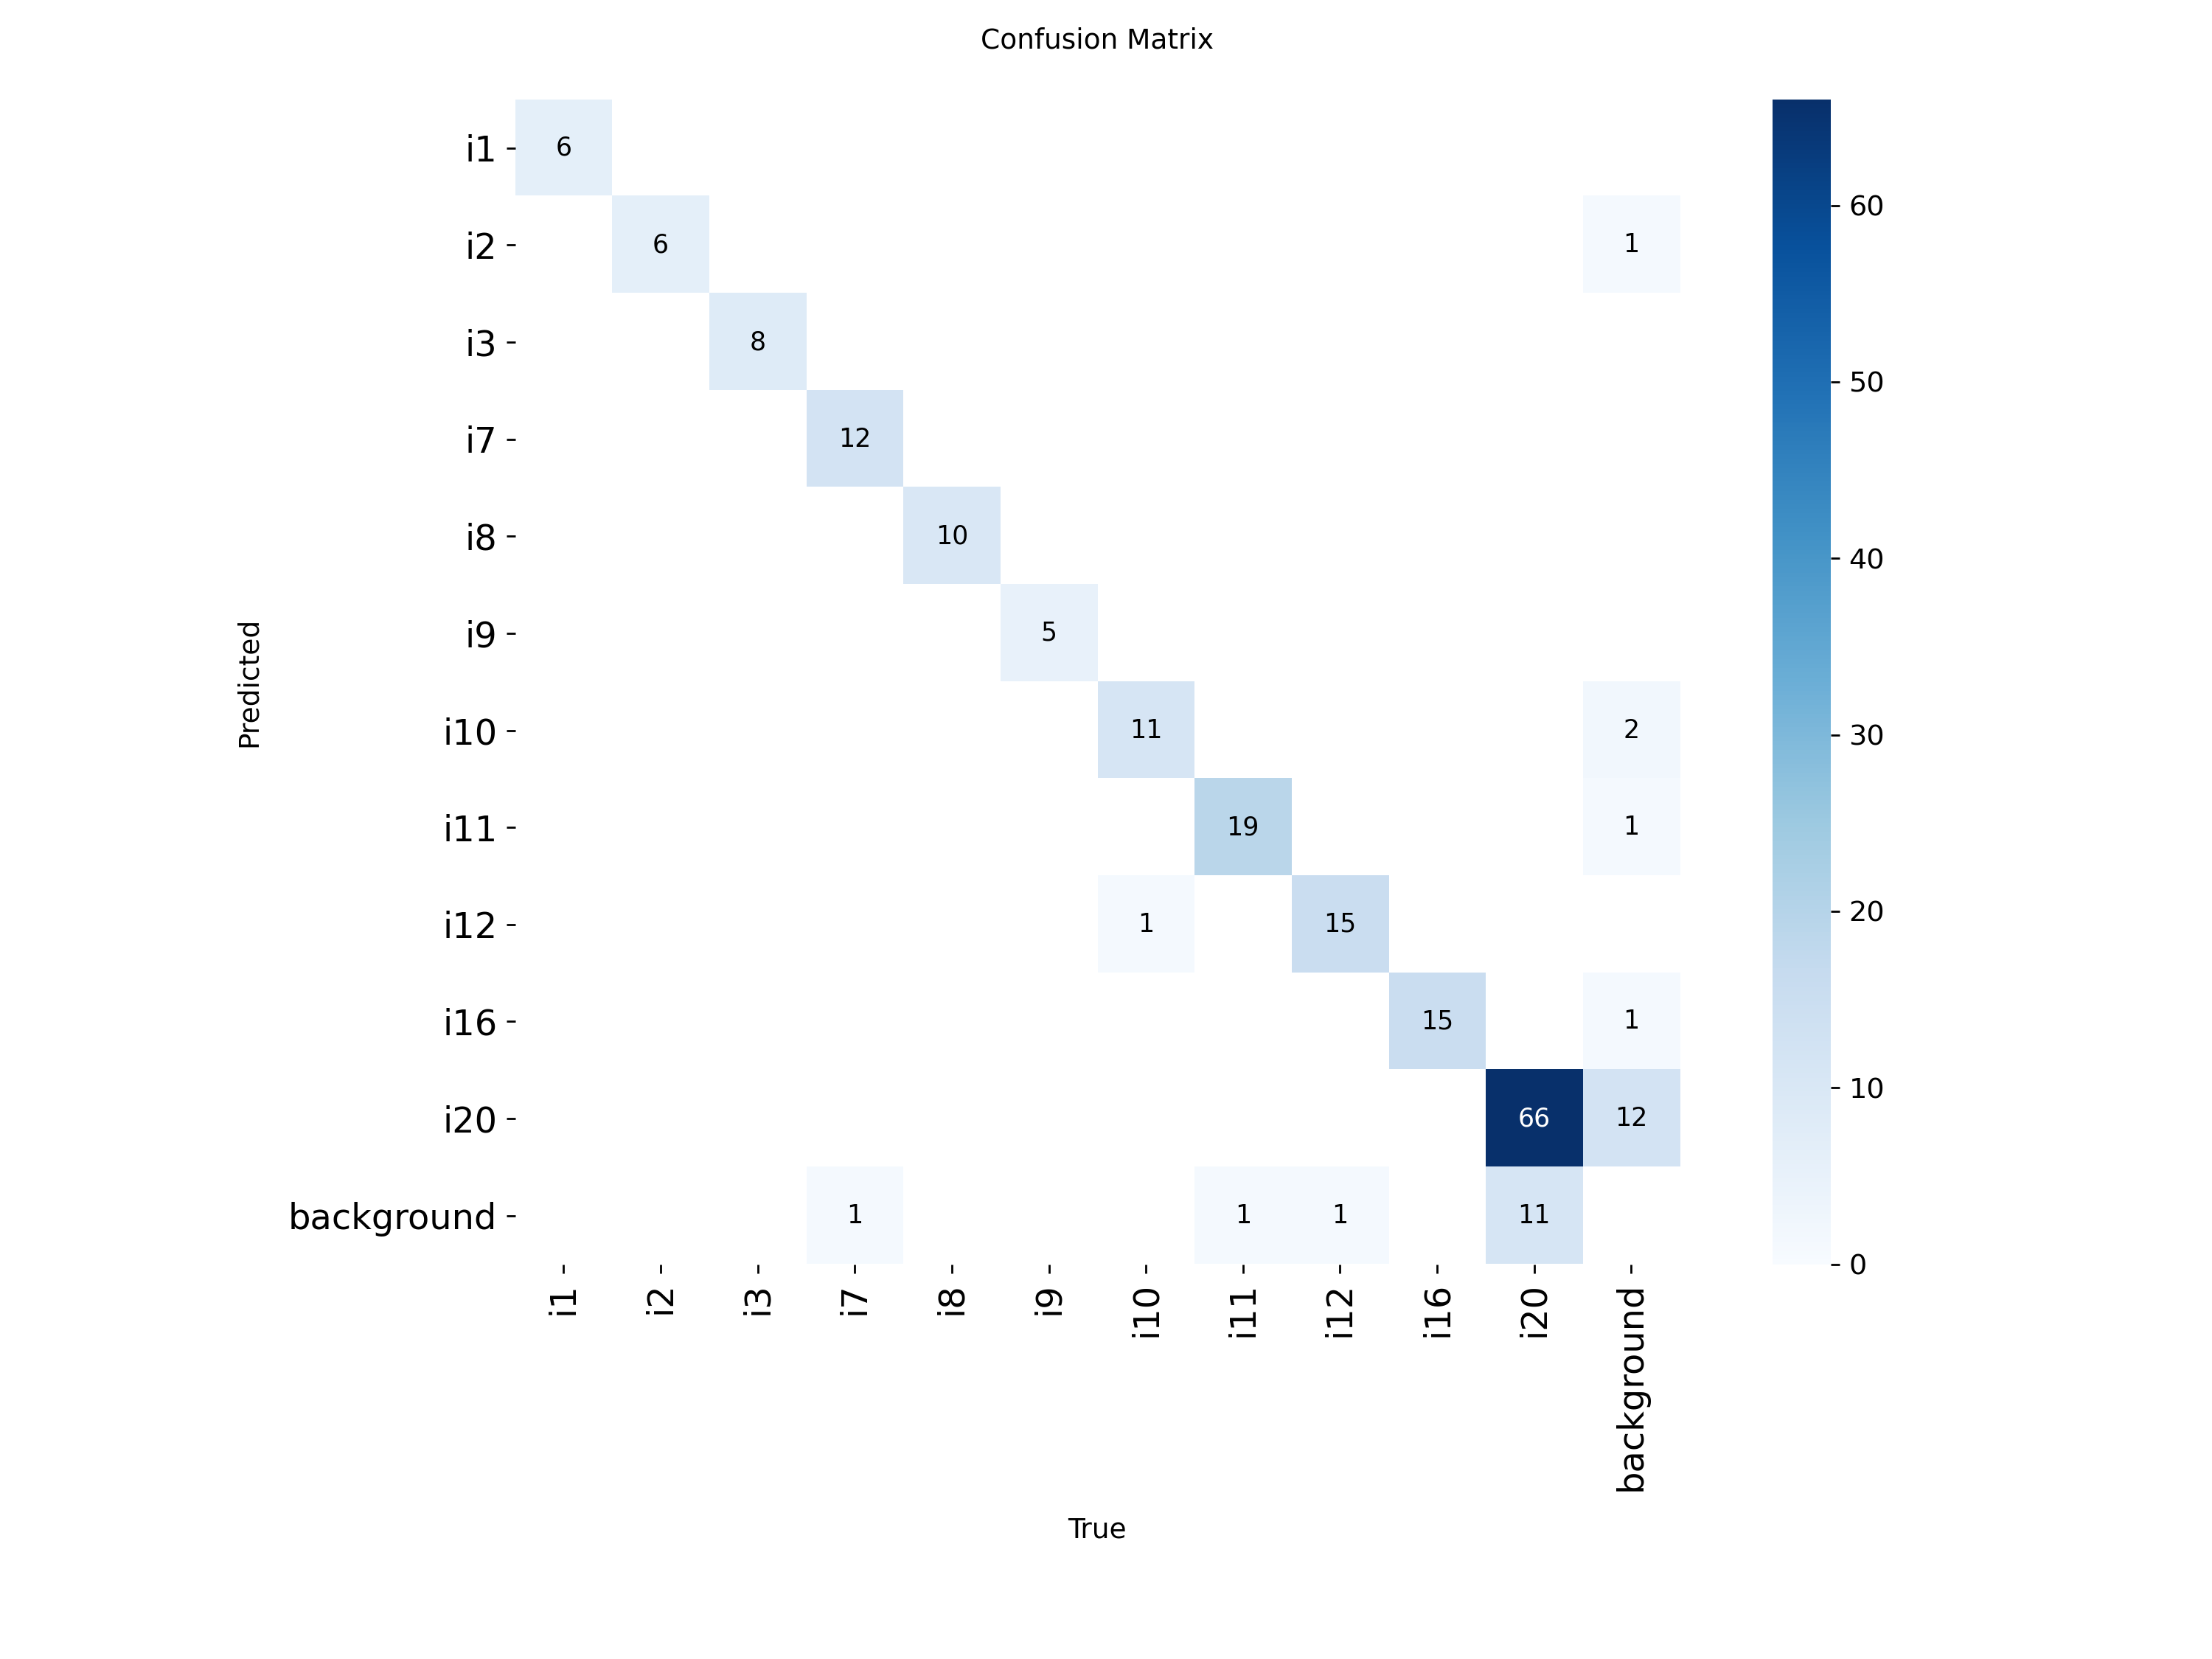

In [ ]:
Image(filename=f"{HOME}/runs/detect/train/confusion_matrix.png", width=IMAGE_WIDTH, height=IMAGE_HEIGHT)

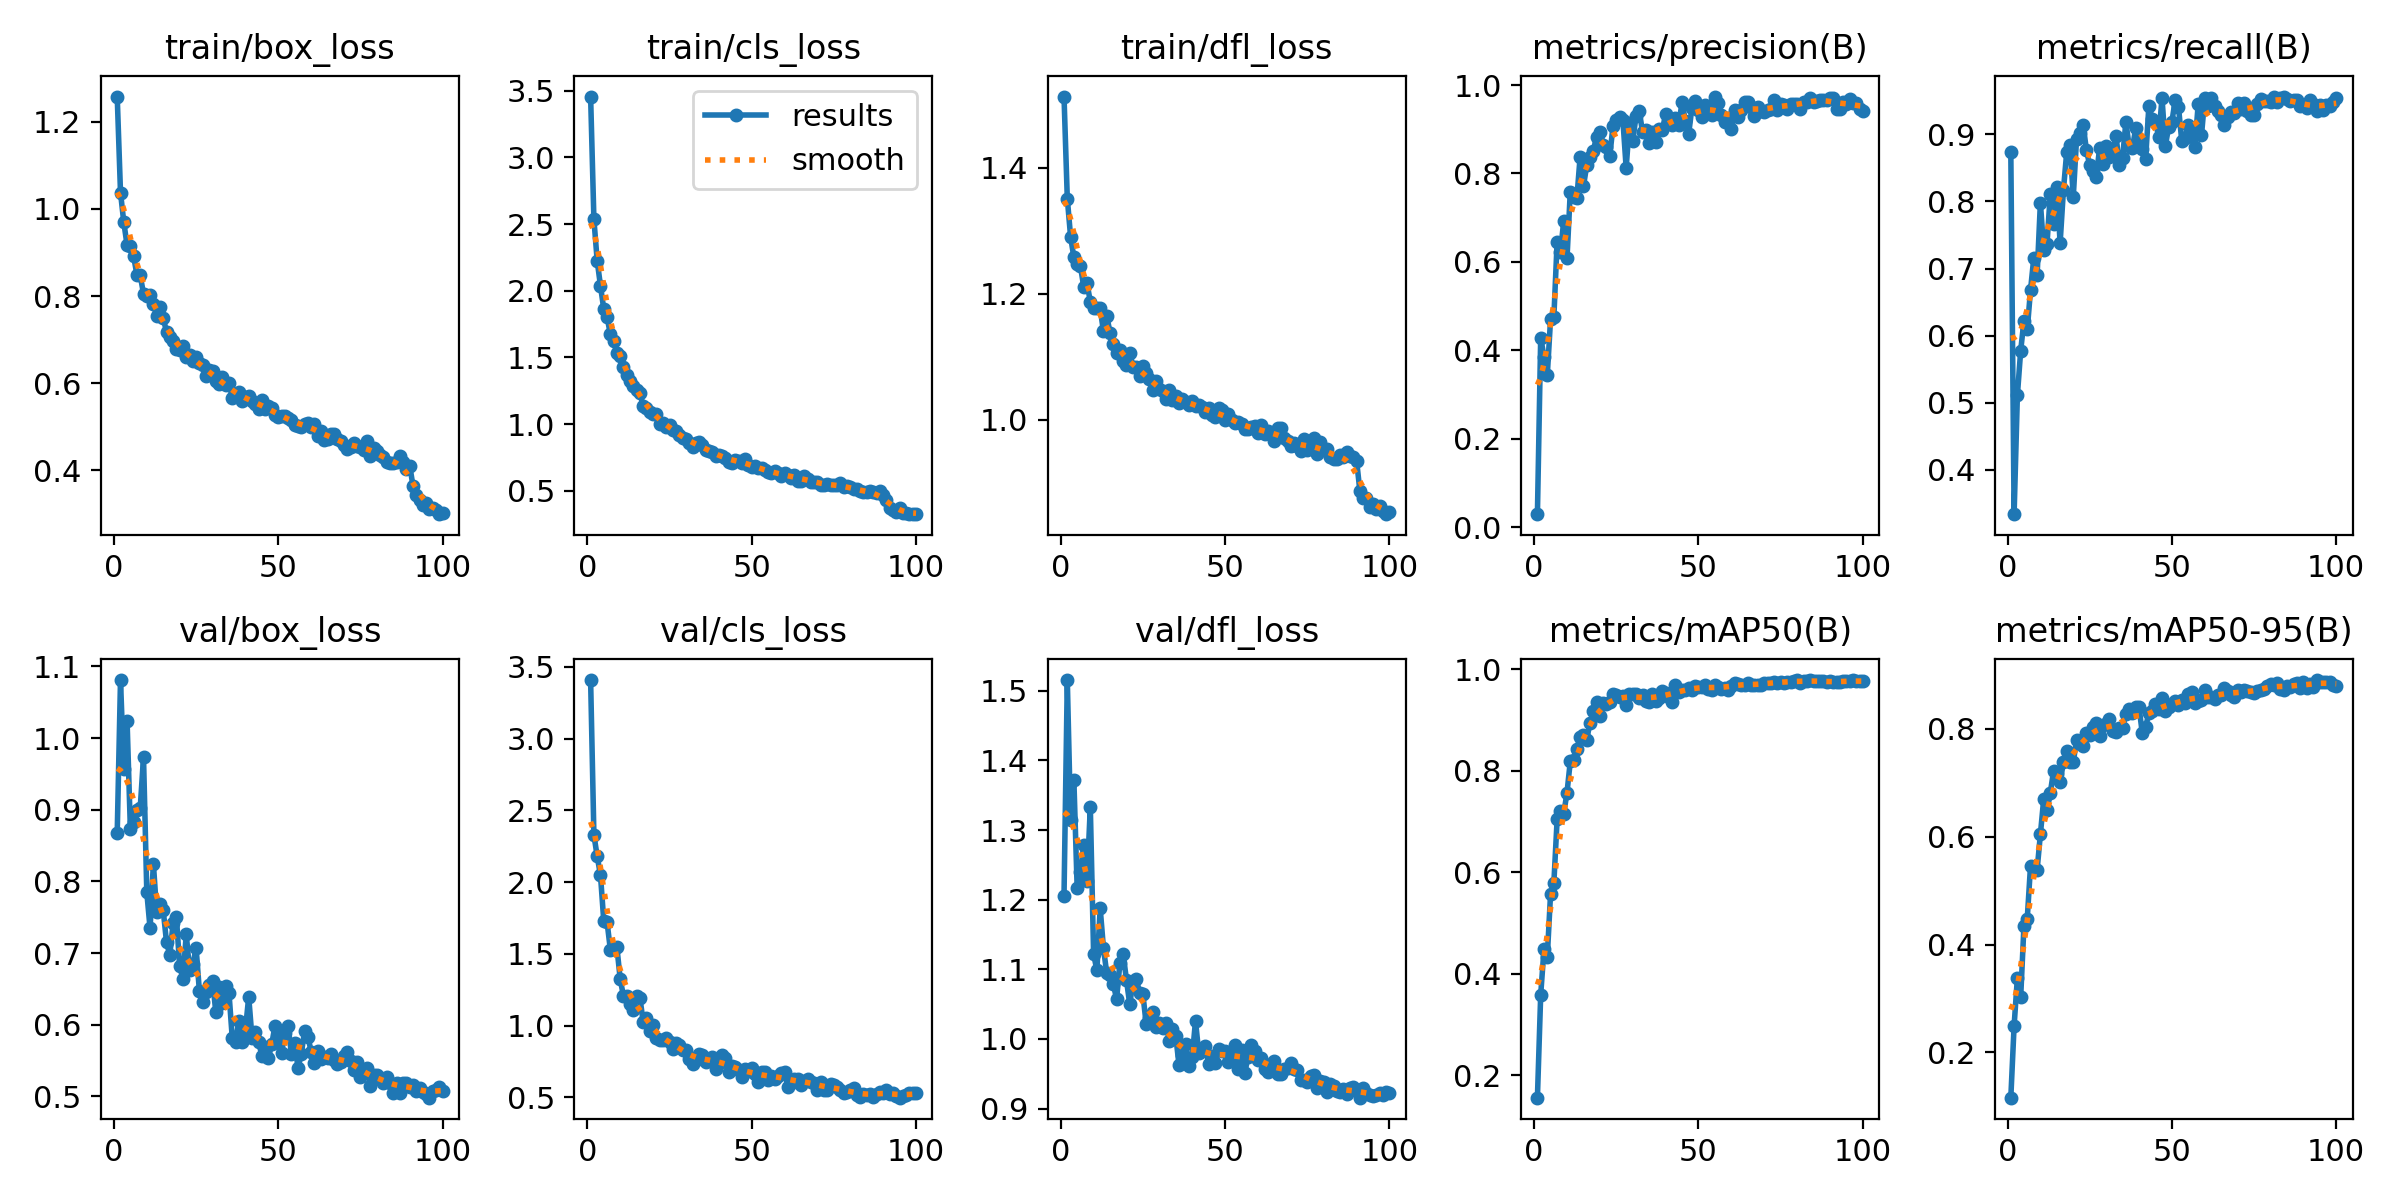

In [ ]:
Image(filename=f"{HOME}/runs/detect/train/results.png", width=IMAGE_WIDTH, height=IMAGE_HEIGHT)

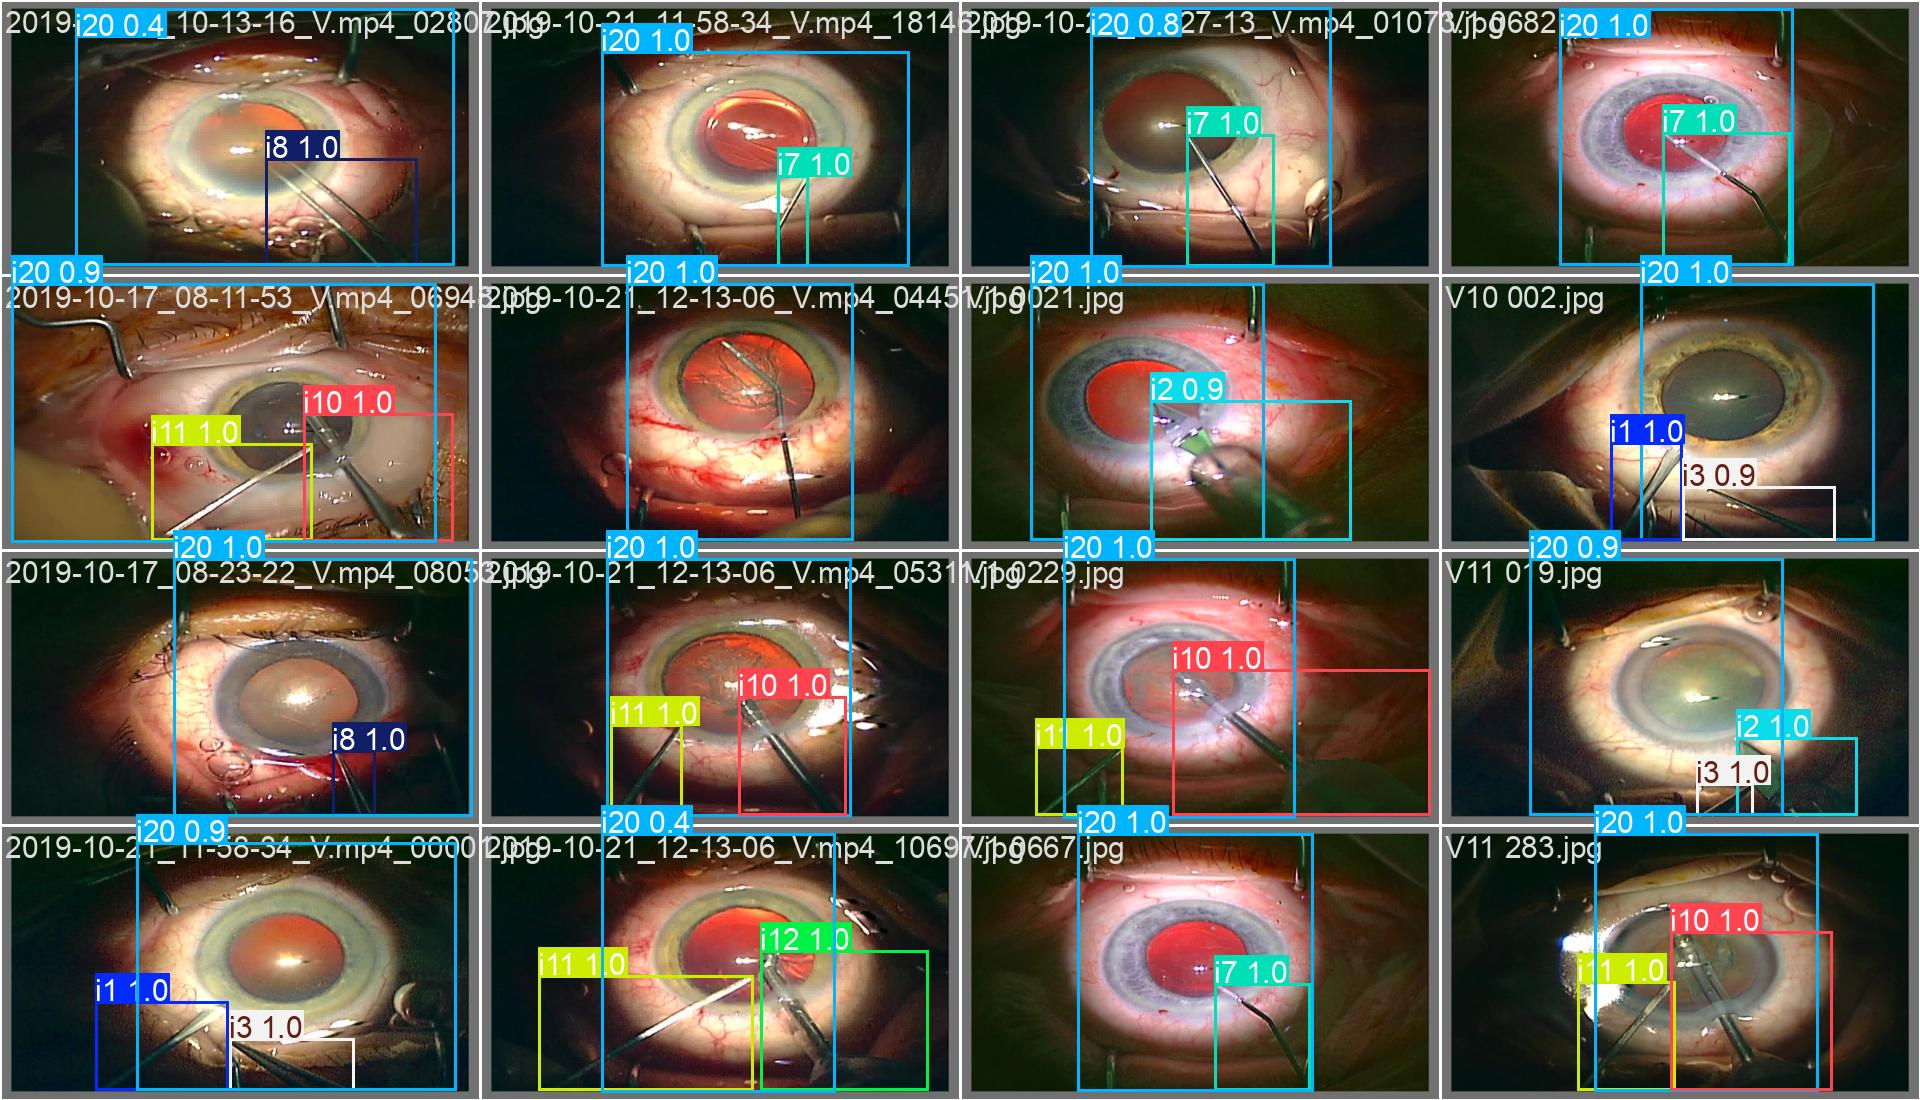

In [ ]:
Image(filename=f"{HOME}/runs/detect/train/val_batch0_pred.jpg", width=IMAGE_WIDTH, height=IMAGE_HEIGHT)

### Validate Custom Model

In [ ]:
!yolo task=detect mode=val \
    data=/content/cataract_dataset_segmentation/data.yaml \
    model=/content/runs/detect/train/weights/best.pt \
    imgsz=640

Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1053.2±135.1 MB/s, size: 83.3 KB)
val: Scanning /content/cataract_dataset_segmentation/labels/val.cache... 84 images, 0 backgrounds, 0 corrupt: 100% 84/84 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:02<00:00,  2.38it/s]
                   all         84        188      0.961      0.934      0.976      0.892
                    i1          6          6      0.949          1      0.995      0.969
                    i2          6          6          1       0.95      0.995      0.914
                    i3          8          8      0.961          1      0.995      0.906
                    i7         13         13      0.998      0.923       0.99      0.861
                    i8         10         10  

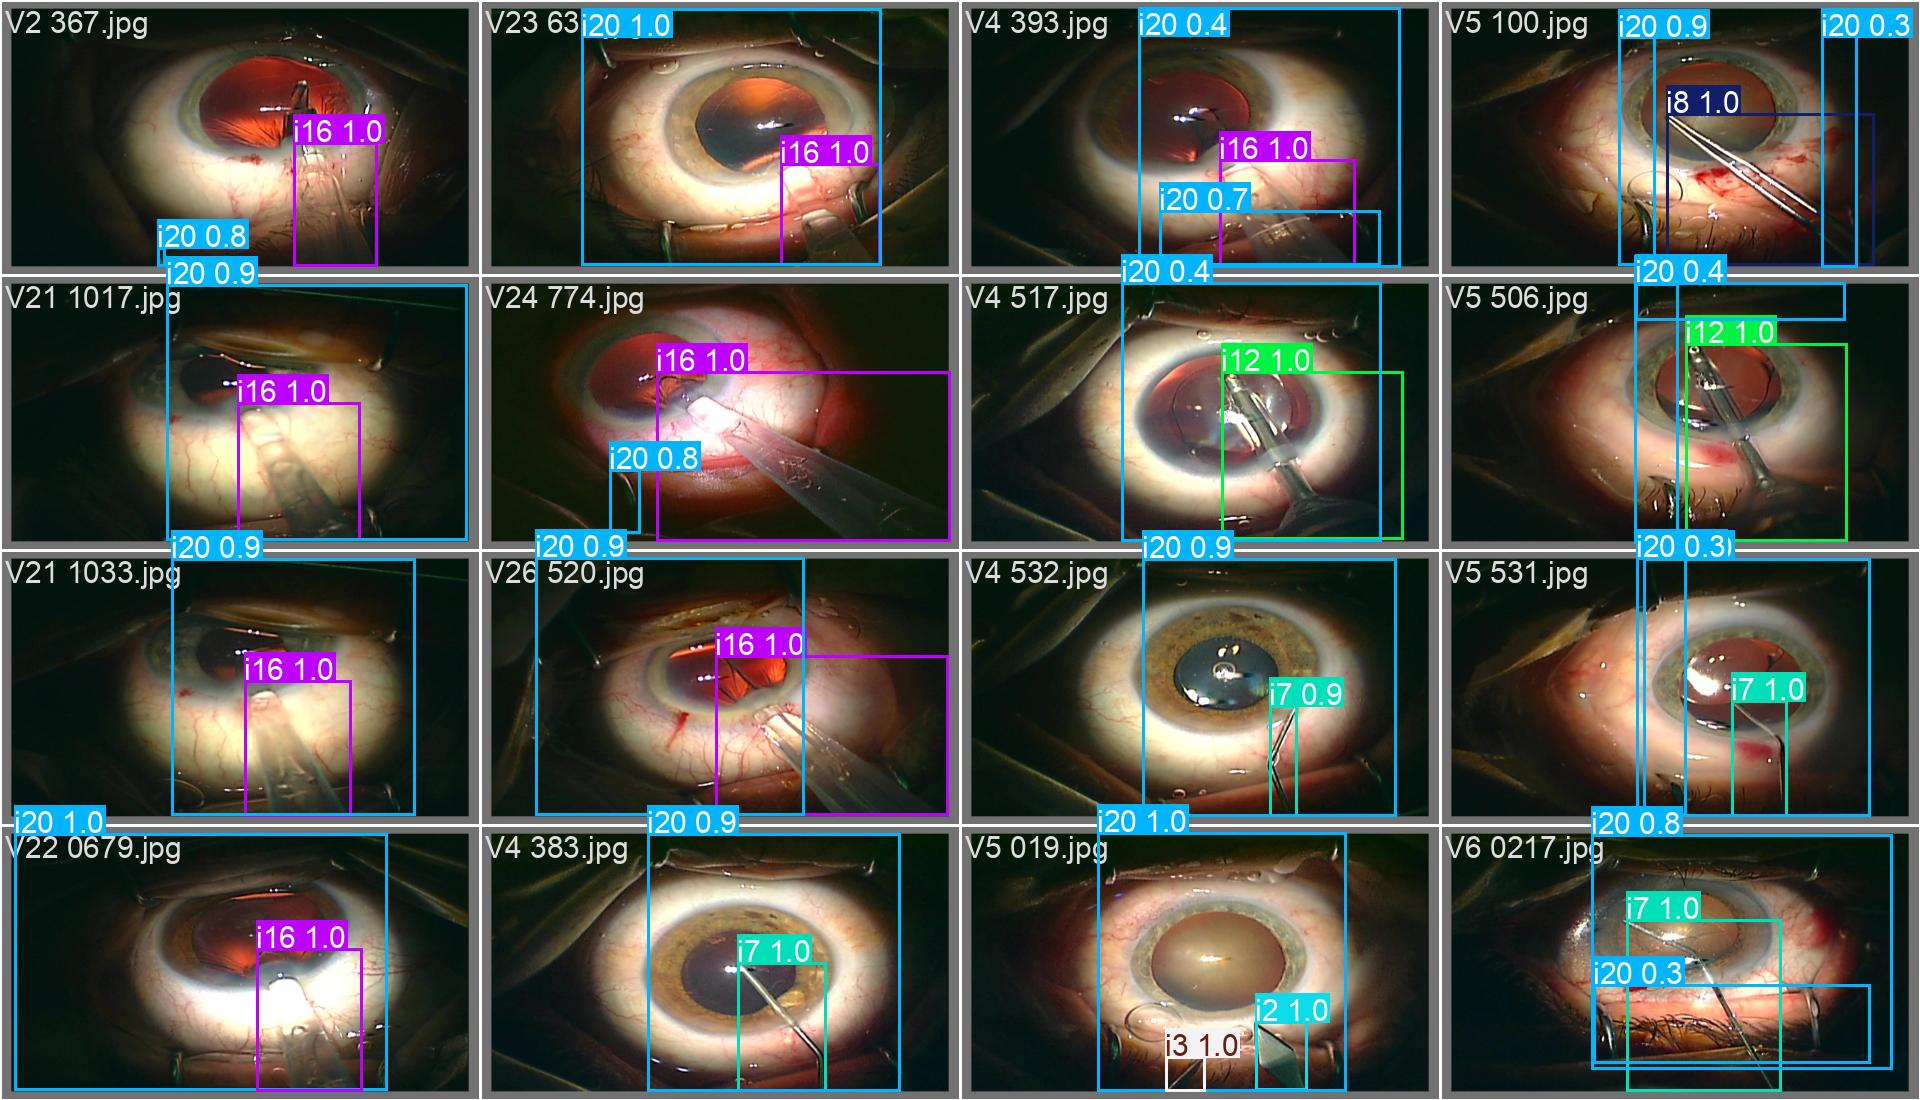

In [ ]:
Image(filename=f"{HOME}/runs/detect/val/val_batch2_pred.jpg", width=IMAGE_WIDTH, height=IMAGE_HEIGHT)

### Inference with Custom Model

In [ ]:
!yolo task=detect mode=predict \
    model=runs/detect/train/weights/best.pt \
    source=/content/cataract_dataset_segmentation/images/test \
    imgsz=640 \
    conf=0.25 \
    save=True

Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs

image 1/85 /content/cataract_dataset_segmentation/images/test/2019-10-16_10-13-16_V.mp4_02467.jpg: 384x640 1 i8, 44.1ms
image 2/85 /content/cataract_dataset_segmentation/images/test/2019-10-16_11-07-49_V.mp4_04000.jpg: 384x640 1 i8, 1 i20, 6.6ms
image 3/85 /content/cataract_dataset_segmentation/images/test/2019-10-17_08-11-53_V.mp4_00205.jpg: 384x640 1 i2, 1 i20, 6.0ms
image 4/85 /content/cataract_dataset_segmentation/images/test/2019-10-17_08-11-53_V.mp4_13542.jpg: 384x640 1 i12, 1 i20, 6.1ms
image 5/85 /content/cataract_dataset_segmentation/images/test/2019-10-17_08-23-22_V.mp4_11678.jpg: 384x640 1 i10, 1 i11, 1 i20, 5.9ms
image 6/85 /content/cataract_dataset_segmentation/images/test/2019-10-21_11-58-34_V.mp4_00086.jpg: 384x640 1 i1, 1 i3, 1 i20, 5.9ms
image 7/85 /content/cataract_dataset_segmentation/images/test/2019-10-2

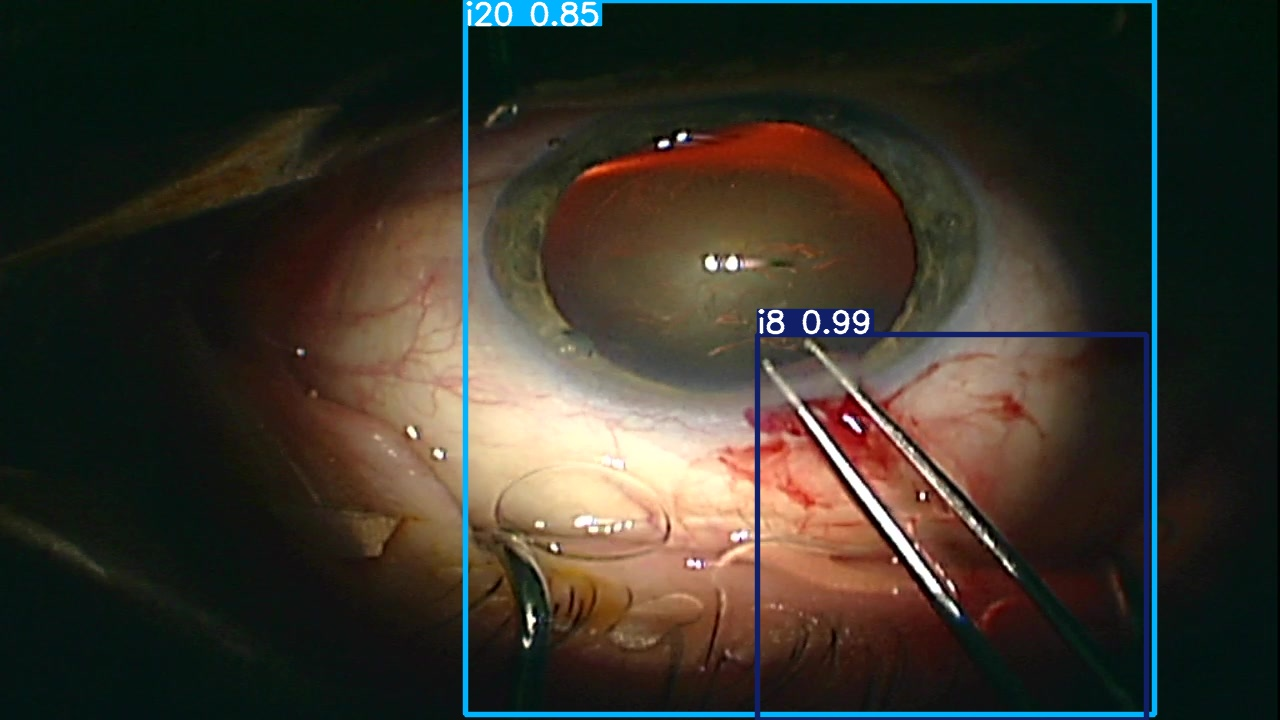

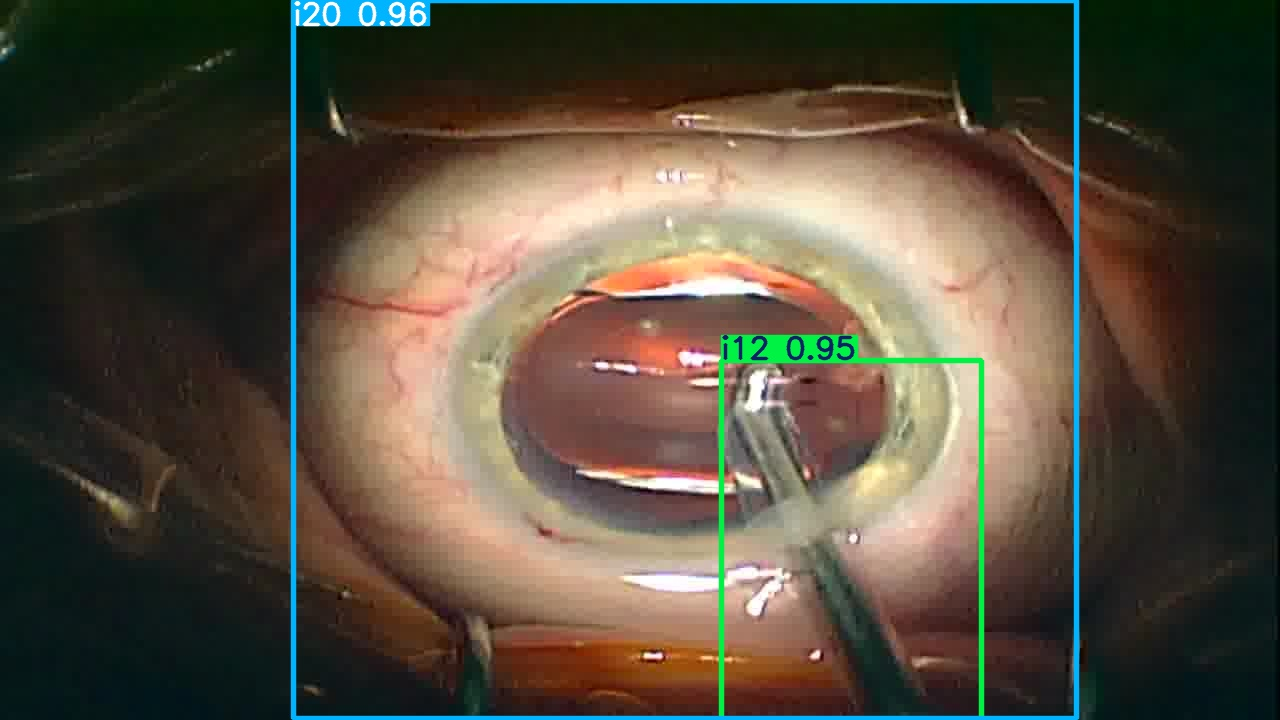

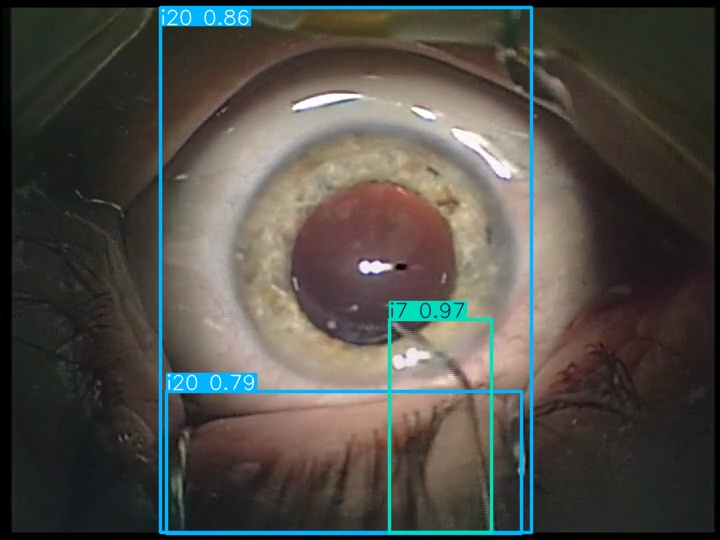

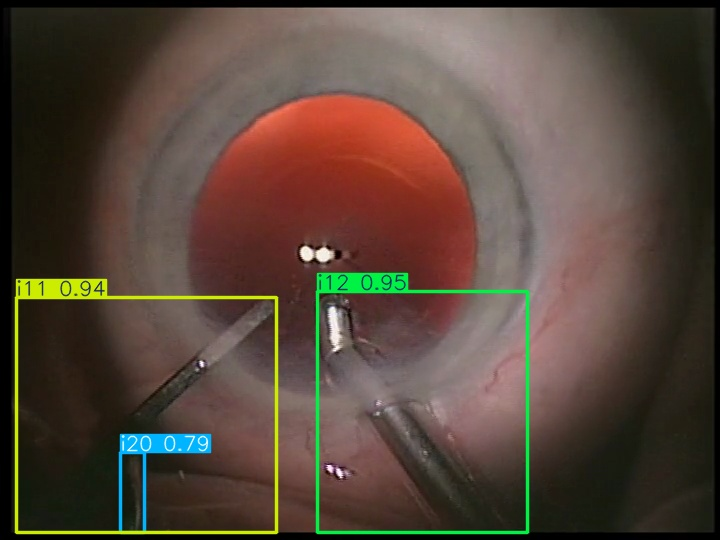

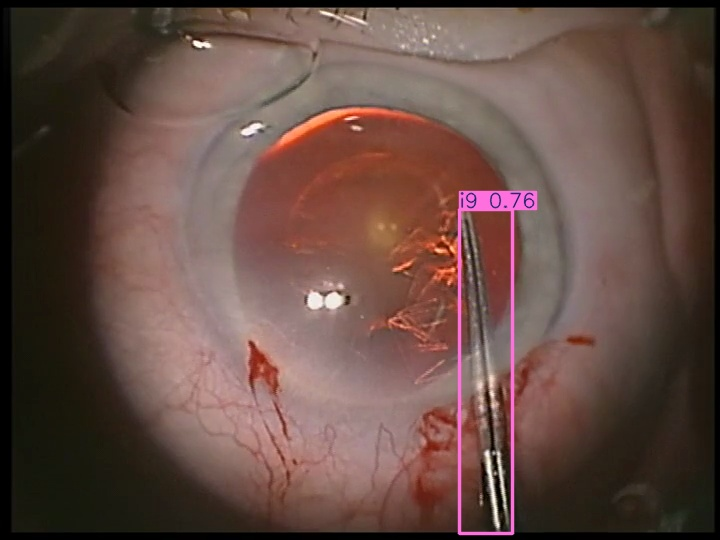

In [ ]:
base_path = '/content/runs/detect/'

subfolders = [os.path.join(base_path, d) for d in os.listdir(base_path)
              if os.path.isdir(os.path.join(base_path, d)) and d.startswith('predict')]

latest_folder = max(subfolders, key=os.path.getmtime)

image_paths = glob.glob(f'{latest_folder}/*.jpg')[:5]

for image_path in image_paths:
    display(Image(filename=image_path, width=640))
    print("\n")

## Second Model

In this section, I will do some data augmentation to see how the model acts

### Data Augmentation

In [ ]:
import os
import cv2
import glob
import random
import albumentations as A

# Data augmentation
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.3),
    A.Blur(blur_limit=3, p=0.15),
    A.RandomScale(scale_limit=0.1, p=0.3),
    A.CoarseDropout(max_holes=3, max_height=20, max_width=20, fill_value=0, p=0.15)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

def augment_dataset(img_dir, lbl_dir, multiplier=2):
    for lbl_path in glob.glob(os.path.join(lbl_dir, "*.txt")):
        with open(lbl_path, "r") as f:
            lines = [l.strip() for l in f if l.strip()]
        if not lines:
            continue

        labels = [line.split() for line in lines]

        img_name = os.path.basename(lbl_path).replace(".txt", ".jpg")
        img_path = os.path.join(img_dir, img_name)
        if not os.path.exists(img_path):
            img_name = img_name.replace(".jpg", ".png")
            img_path = os.path.join(img_dir, img_name)
            if not os.path.exists(img_path):
                print(f"Image for {lbl_path} not found.")
                continue

        image = cv2.imread(img_path)
        if image is None:
            print(f"Couldn't read {img_path}, skipping.")
            continue

        bboxes = [list(map(float, l[1:5])) for l in labels]
        cls_labels = [int(l[0]) for l in labels]

        for k in range(multiplier):
            try:
                aug = transform(image=image, bboxes=bboxes, class_labels=cls_labels)
            except Exception as e:
                print("Augmentation failed:", e)
                continue

            aug_img = aug['image']
            aug_bboxes = aug['bboxes']
            aug_labels = aug['class_labels']

            if len(aug_bboxes) == 0:
                continue


            base, ext = os.path.splitext(img_name)
            new_img_name = f"{base}_aug{random.randint(10000,99999)}{ext}"
            new_img_path = os.path.join(img_dir, new_img_name)
            new_lbl_path = os.path.join(lbl_dir, new_img_name.replace(ext, ".txt"))

            cv2.imwrite(new_img_path, aug_img)
            with open(new_lbl_path, "w") as f:
                for cid, bb in zip(aug_labels, aug_bboxes):
                    f.write(f"{cid} {' '.join(map(str, bb))}\n")

    print("Augmentation done.")

augment_dataset(
    img_dir=os.path.join("/content/cataract_dataset_segmentation/images", "train"),
    lbl_dir=os.path.join("/content/cataract_dataset_segmentation/labels", "train"),
    multiplier=2
)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-607841001.py:15: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=3, max_height=20, max_width=20, fill_value=0, p=0.15)
/usr/local/lib/python3.11/dist-packages/albumentations/augmentations/dropout/functional.py:559: RuntimeWarning: invalid value encountered in divide
  visibility_ratios = remaining_areas / box_areas


✅ Augmentation done.


### Custom Training

In [ ]:
!yolo task=detect mode=train \
    data=/content/cataract_dataset_segmentation/data.yaml \
    model=yolov8n.pt \
    epochs=100 \
    imgsz=640 \
    batch=16 \
    plots=True \
    augment=True

Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/cataract_dataset_segmentation/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, 

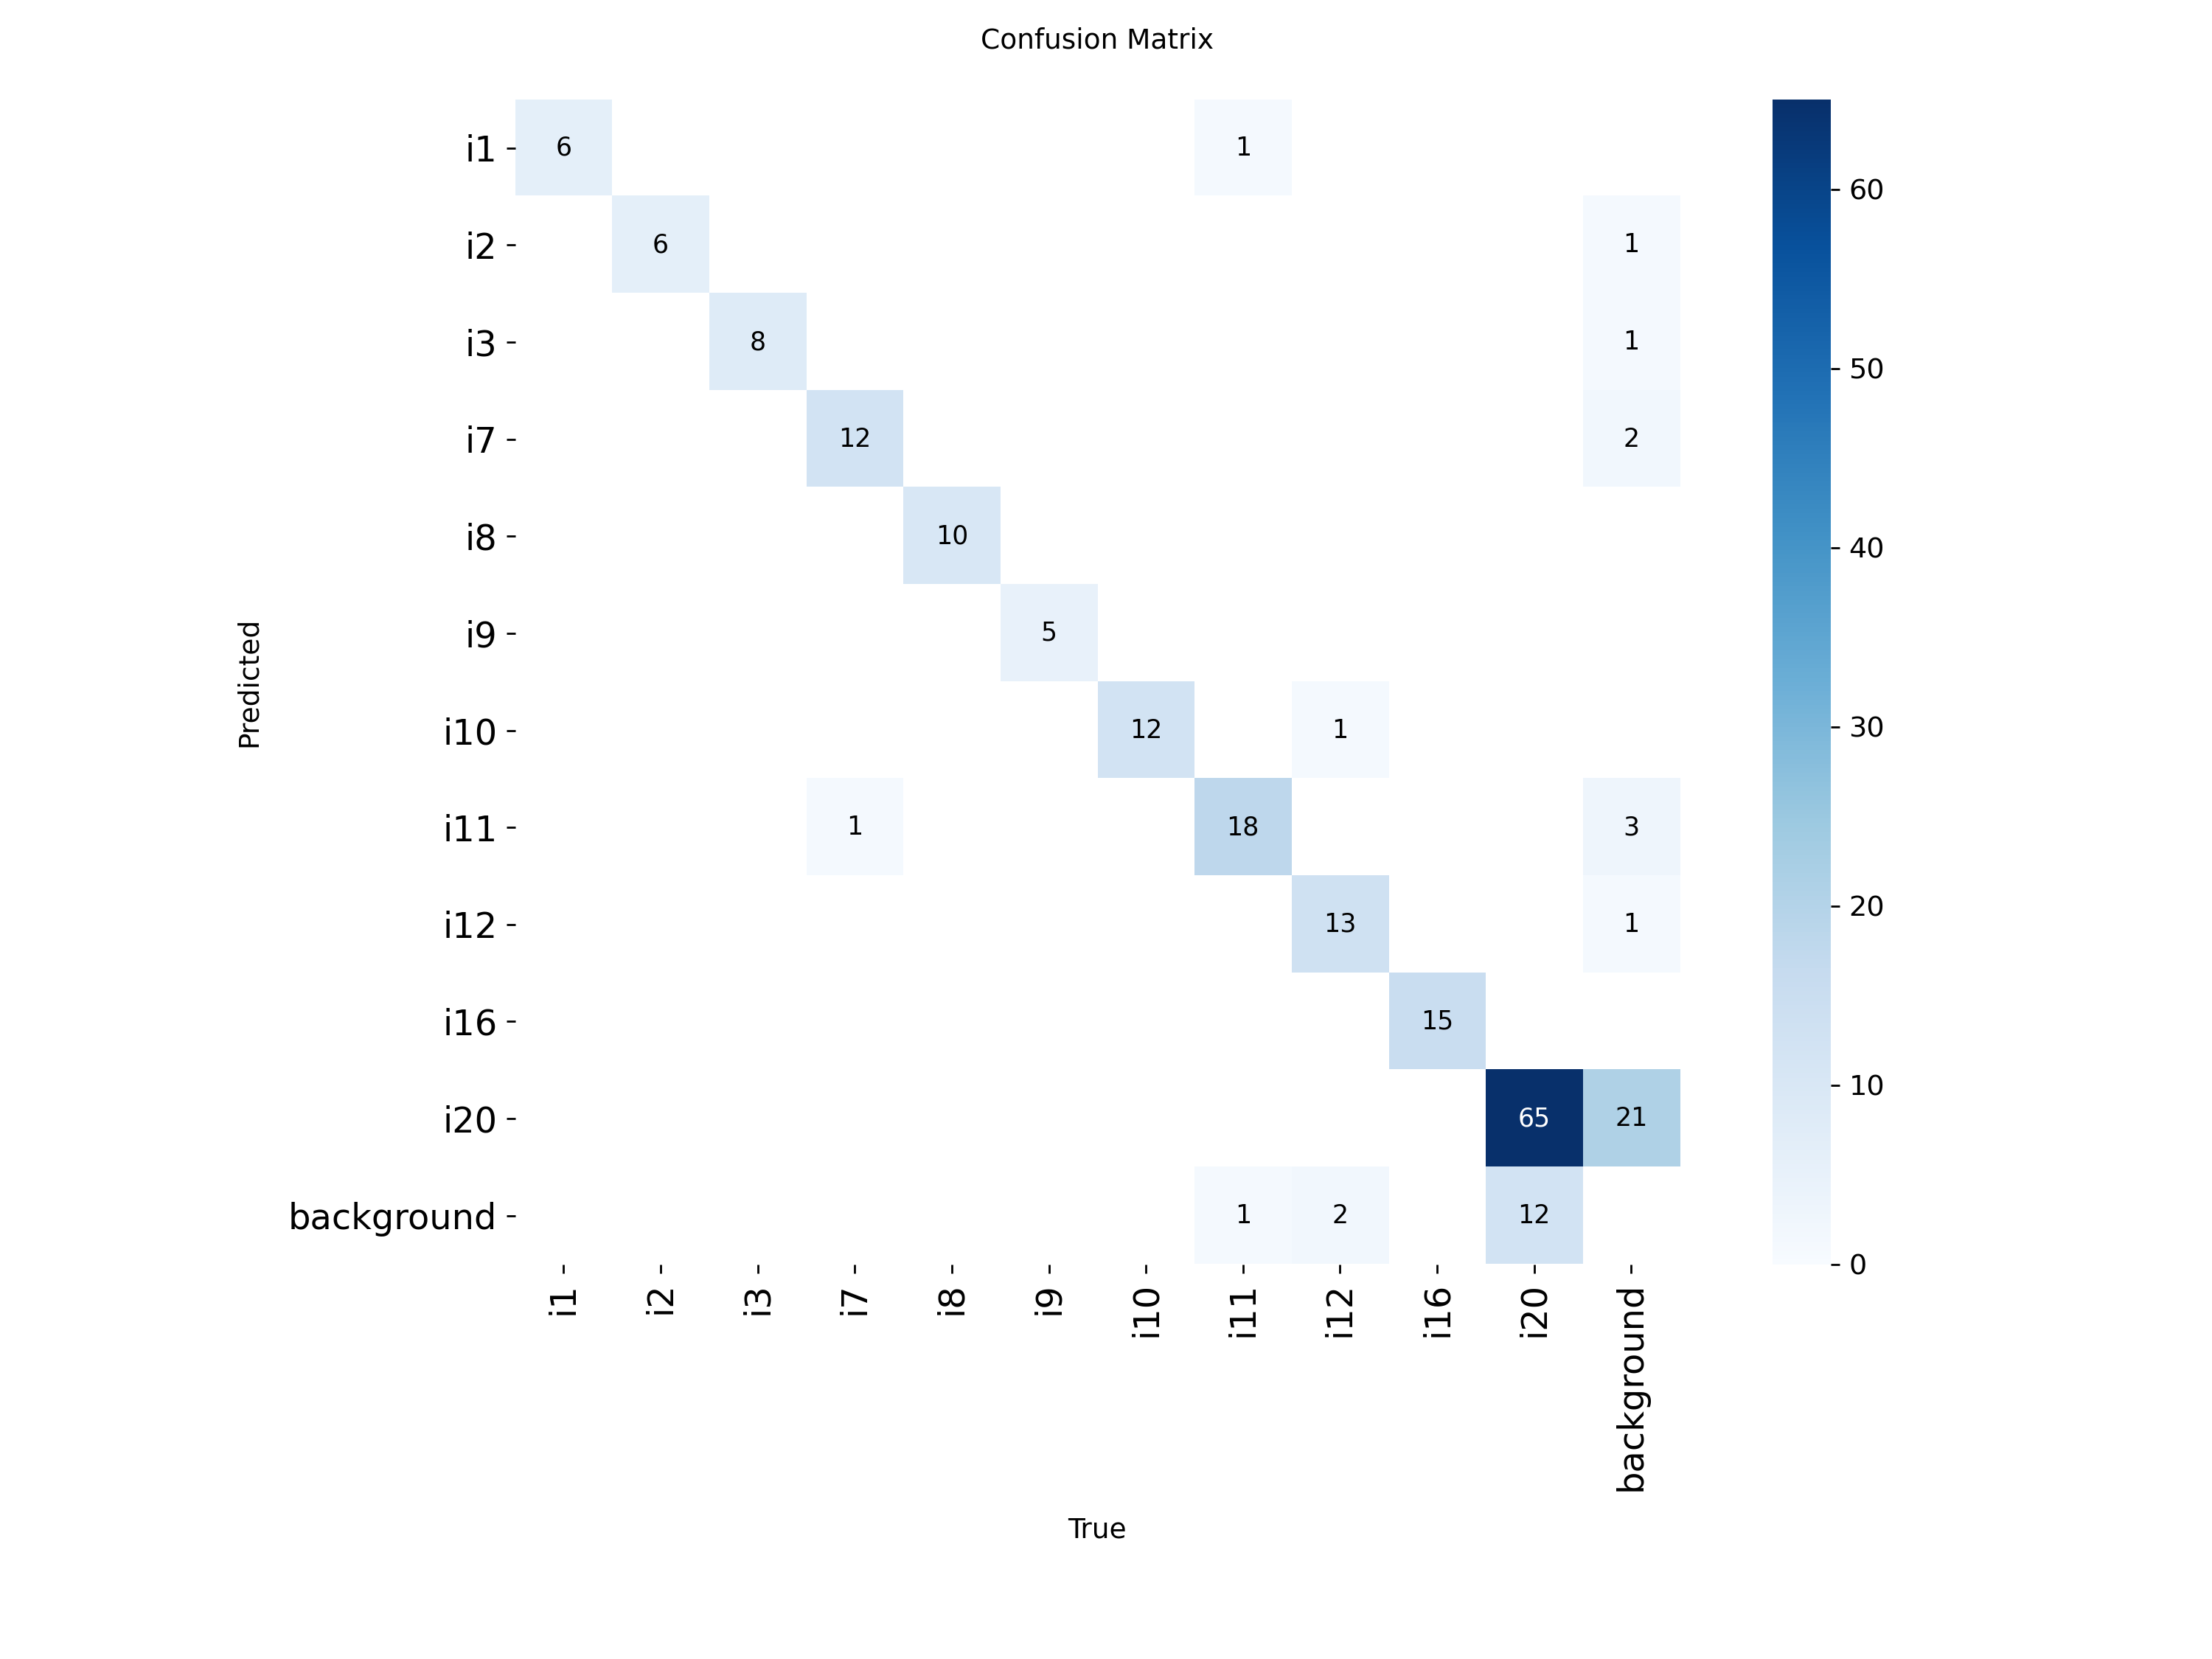

In [ ]:
Image(filename=f"{HOME}/runs/detect/train4/confusion_matrix.png", width=IMAGE_WIDTH, height=IMAGE_HEIGHT)

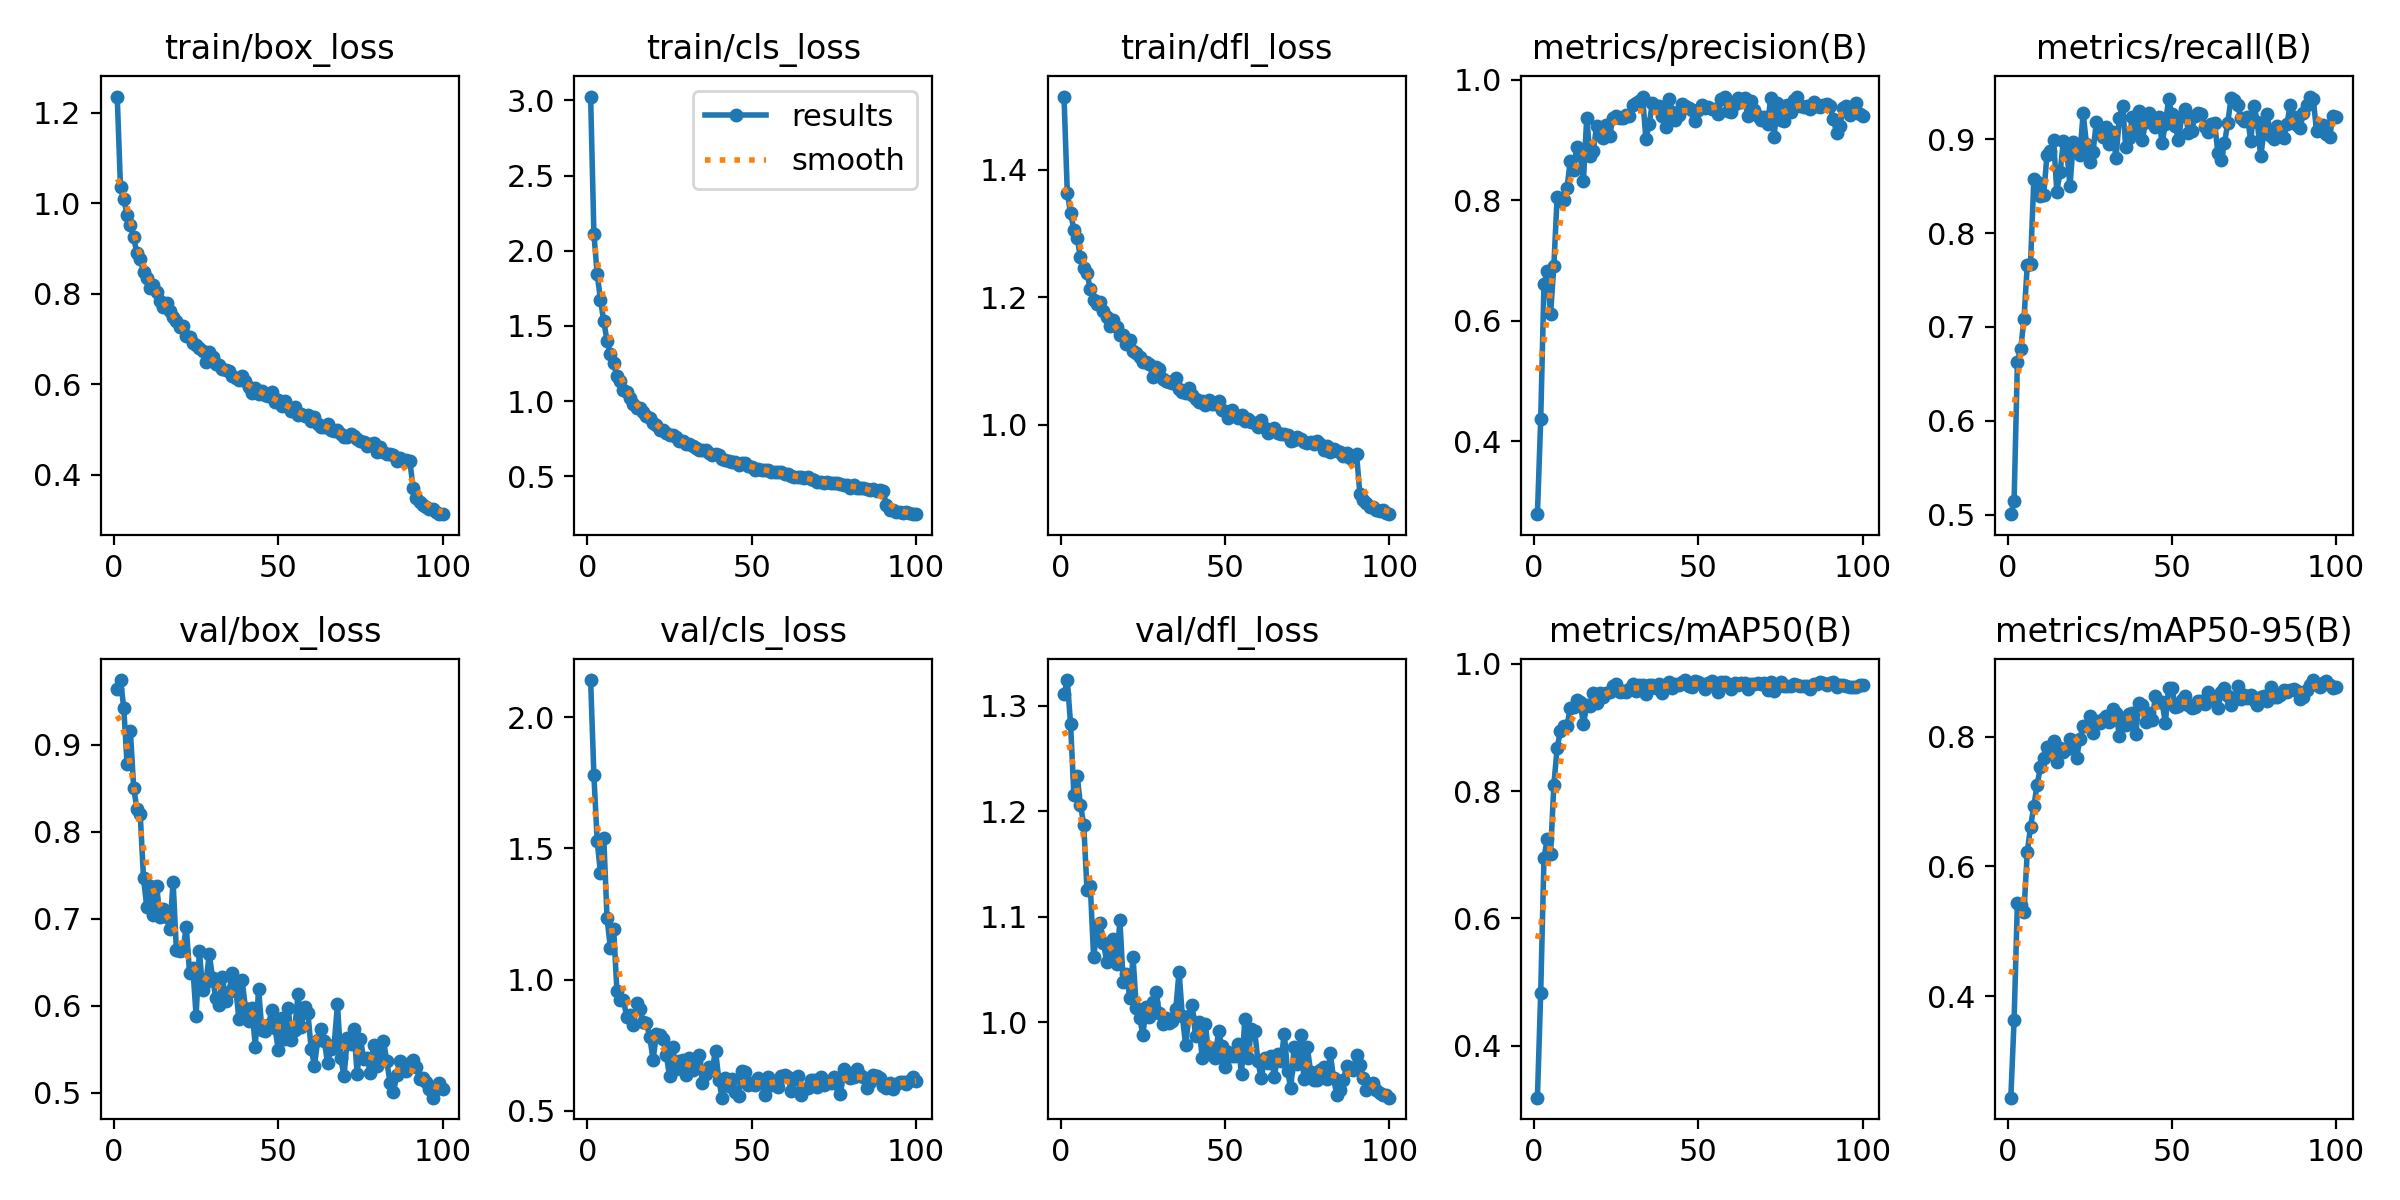

In [ ]:
Image(filename=f"{HOME}/runs/detect/train4/results.png", width=IMAGE_WIDTH)

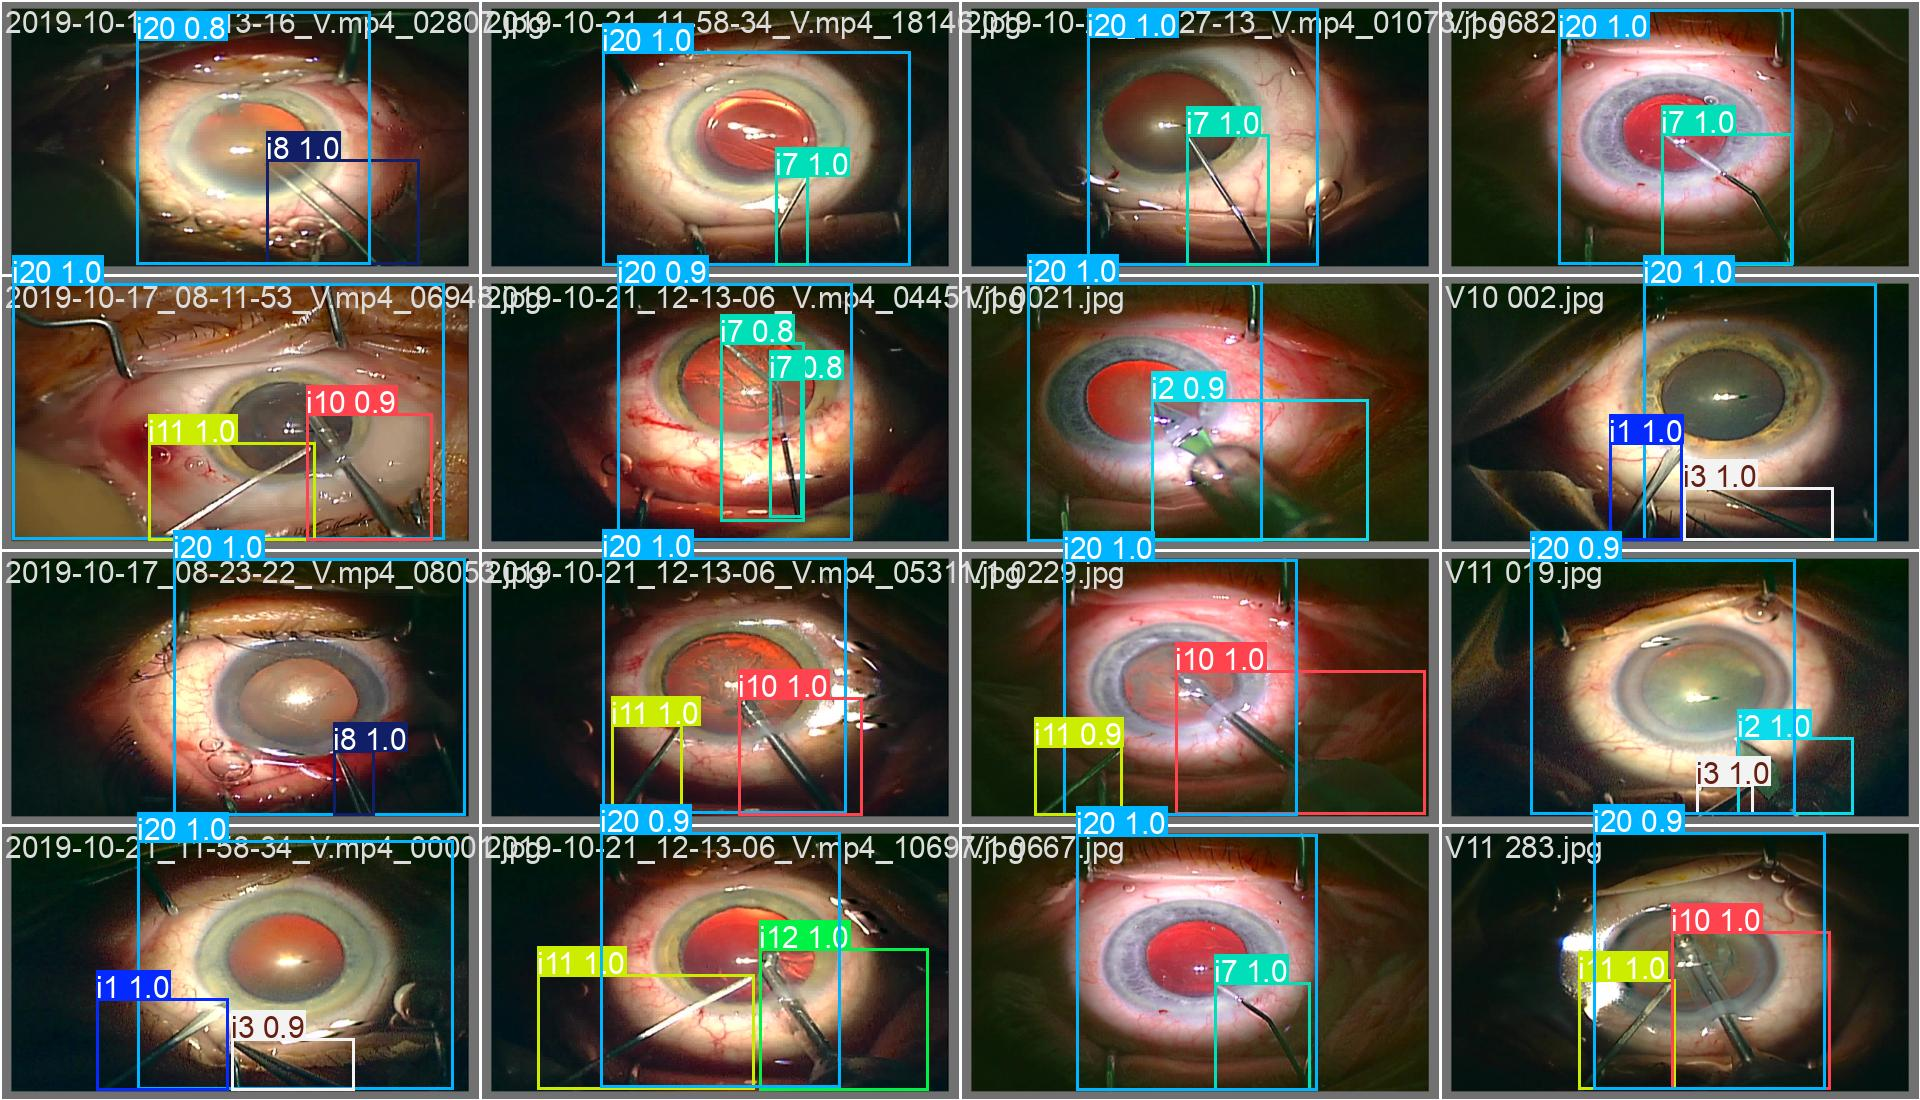

In [ ]:
Image(filename=f"{HOME}/runs/detect/train4/val_batch0_pred.jpg", width=IMAGE_WIDTH, height=IMAGE_HEIGHT)

### Validate Custom Model

In [ ]:
!yolo task=detect mode=val \
    data=/content/cataract_dataset_segmentation/data.yaml \
    model=/content/runs/detect/train4/weights/best.pt \
    imgsz=640

Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1934.1±837.6 MB/s, size: 290.2 KB)
val: Scanning /content/cataract_dataset_segmentation/labels/val.cache... 84 images, 0 backgrounds, 0 corrupt: 100% 84/84 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:02<00:00,  2.45it/s]
                   all         84        188      0.925      0.944      0.966      0.887
                    i1          6          6      0.816          1      0.995      0.926
                    i2          6          6       0.85      0.949      0.972      0.899
                    i3          8          8      0.961          1      0.995      0.893
                    i7         13         13      0.989      0.923      0.939      0.869
                    i8         10         10 

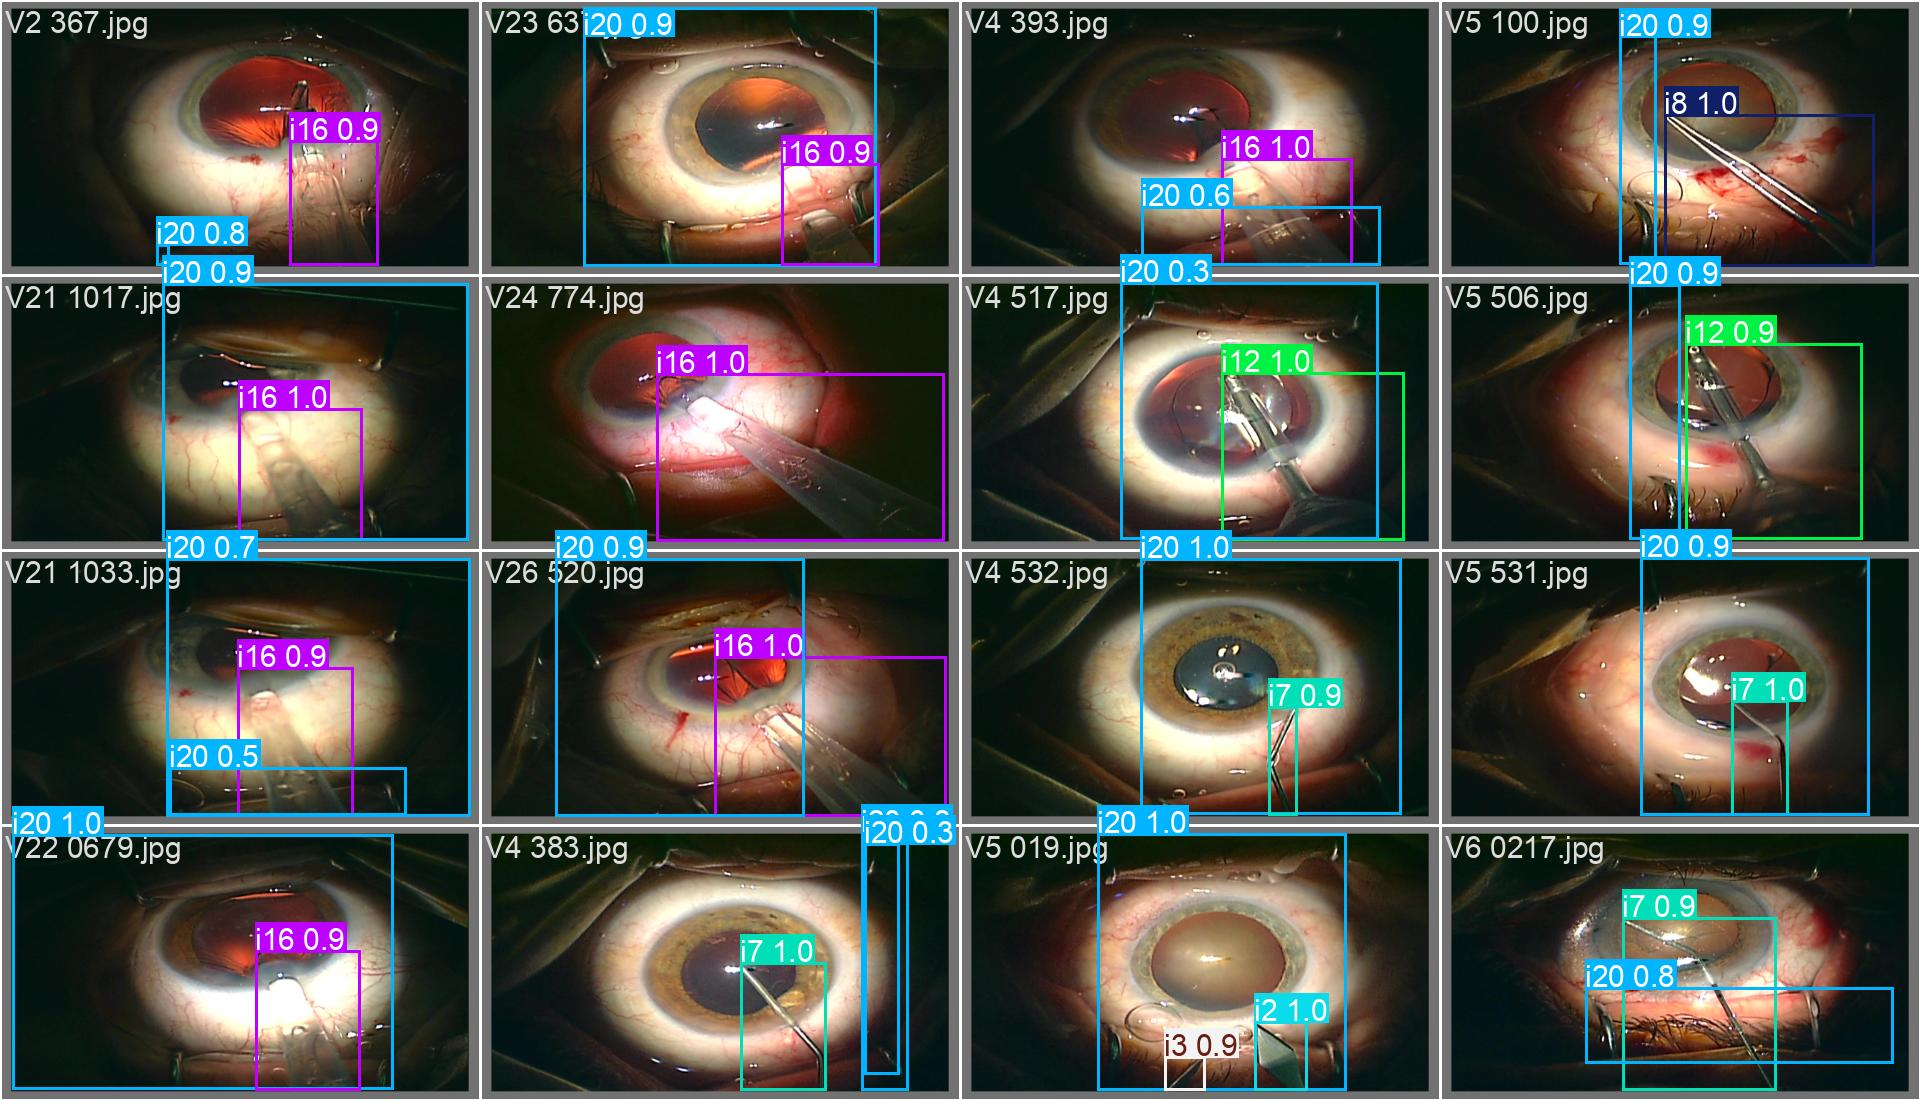

In [ ]:
Image(filename=f"{HOME}/runs/detect/val2/val_batch2_pred.jpg", width=IMAGE_WIDTH, height=IMAGE_HEIGHT)

### Inference with Custom Model

In [ ]:
!yolo task=detect mode=predict \
    model=runs/detect/train4/weights/best.pt \
    source=/content/cataract_dataset_segmentation/images/test \
    imgsz=640 \
    conf=0.25 \
    save=True

Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs

image 1/85 /content/cataract_dataset_segmentation/images/test/2019-10-16_10-13-16_V.mp4_02467.jpg: 384x640 1 i8, 40.6ms
image 2/85 /content/cataract_dataset_segmentation/images/test/2019-10-16_11-07-49_V.mp4_04000.jpg: 384x640 1 i8, 1 i20, 6.4ms
image 3/85 /content/cataract_dataset_segmentation/images/test/2019-10-17_08-11-53_V.mp4_00205.jpg: 384x640 1 i2, 1 i20, 6.0ms
image 4/85 /content/cataract_dataset_segmentation/images/test/2019-10-17_08-11-53_V.mp4_13542.jpg: 384x640 1 i12, 1 i20, 6.4ms
image 5/85 /content/cataract_dataset_segmentation/images/test/2019-10-17_08-23-22_V.mp4_11678.jpg: 384x640 1 i10, 1 i11, 1 i20, 6.2ms
image 6/85 /content/cataract_dataset_segmentation/images/test/2019-10-21_11-58-34_V.mp4_00086.jpg: 384x640 1 i1, 1 i3, 1 i20, 6.2ms
image 7/85 /content/cataract_dataset_segmentation/images/test/2019-10-2

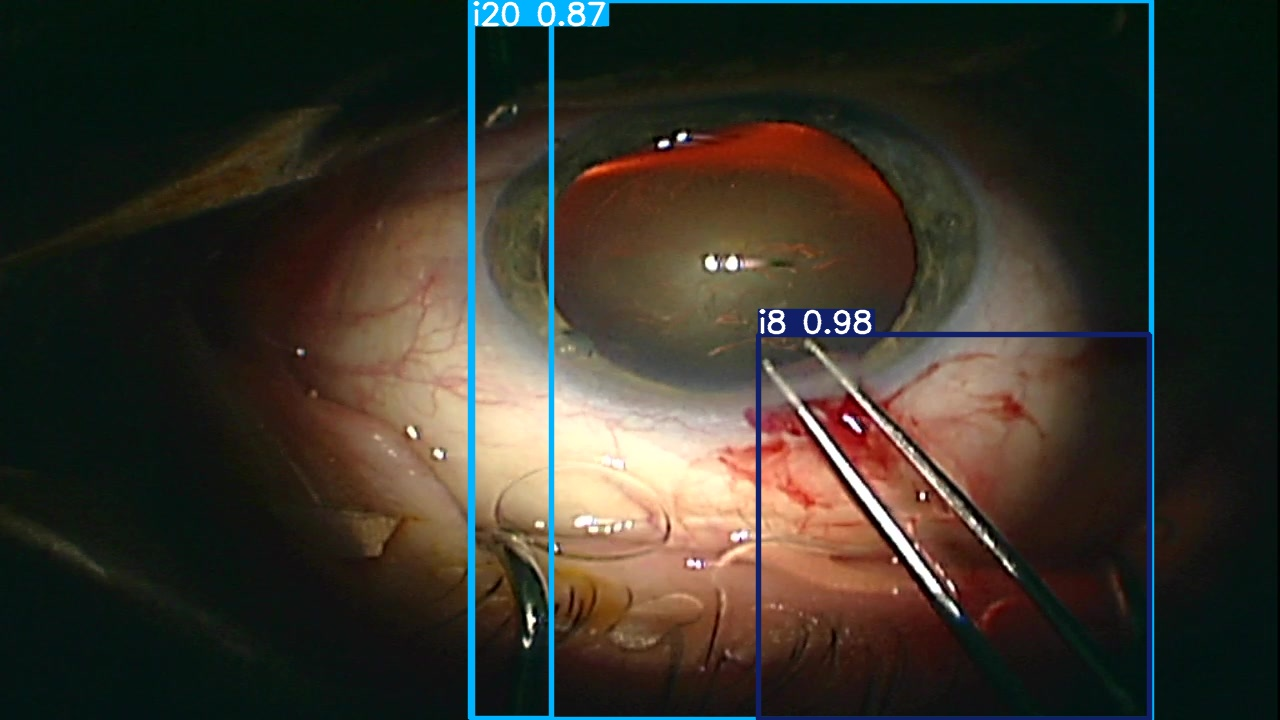

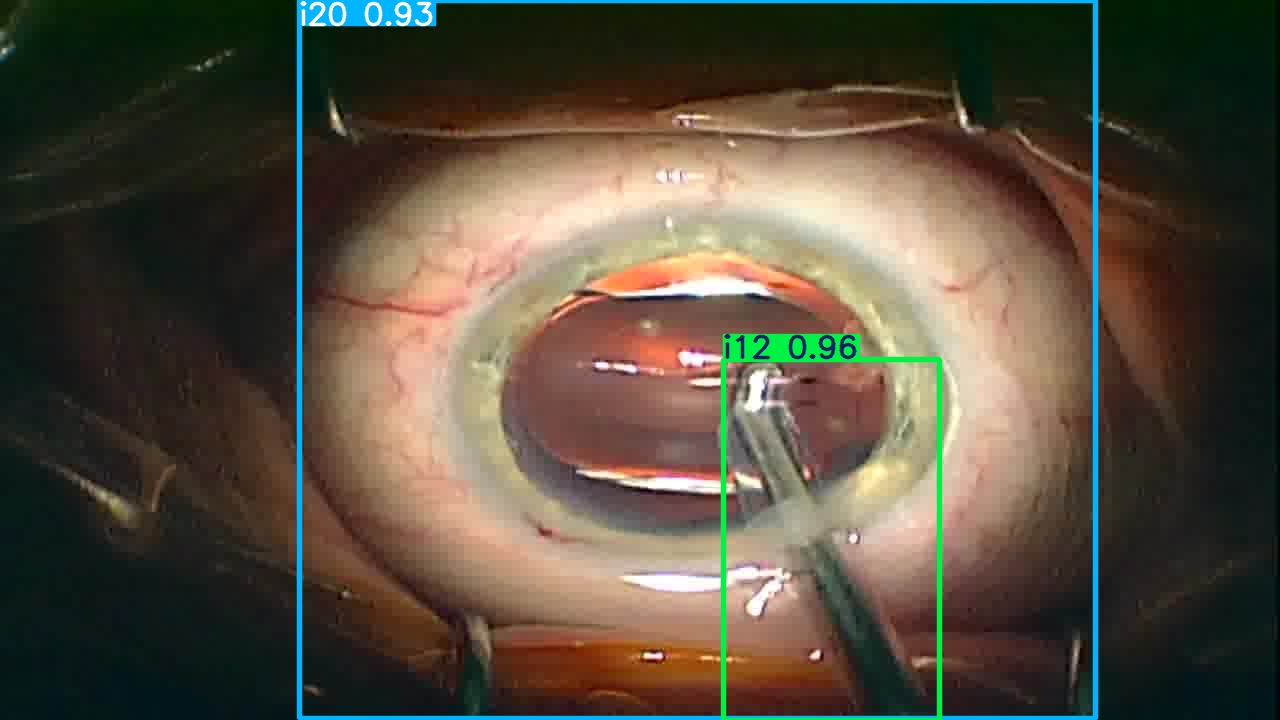

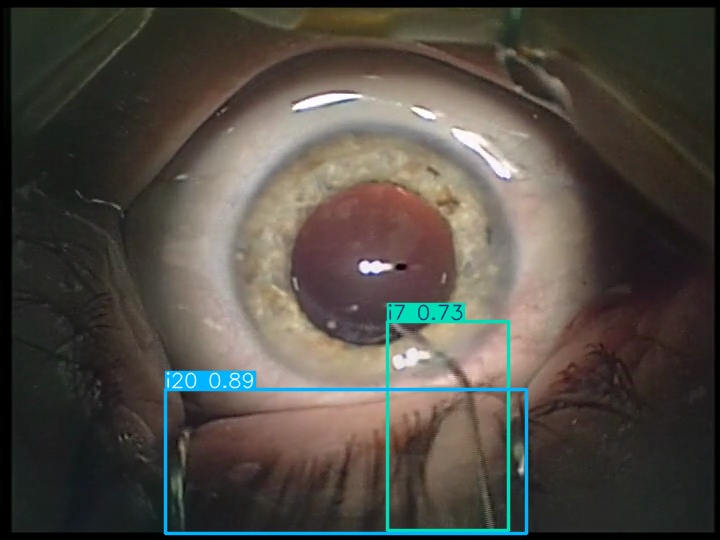

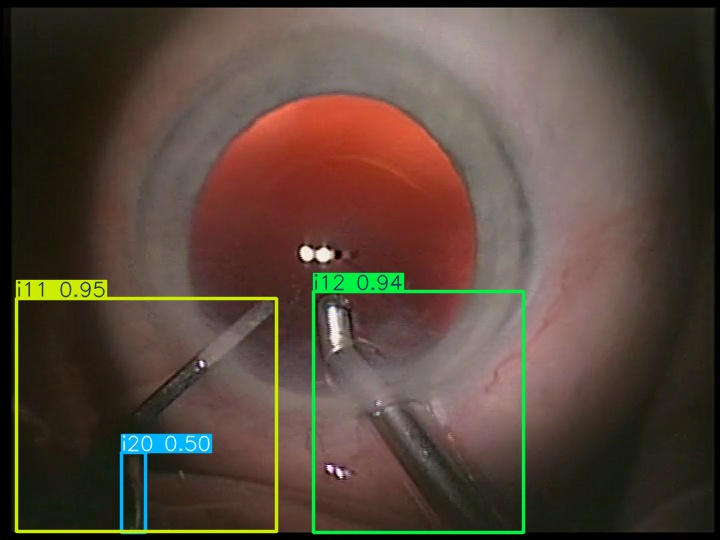

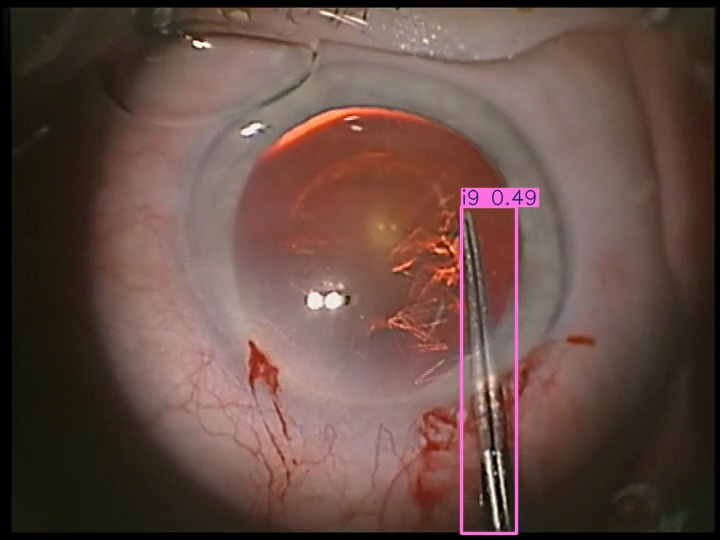

In [ ]:
base_path = '/content/runs/detect/'

subfolders = [os.path.join(base_path, d) for d in os.listdir(base_path)
              if os.path.isdir(os.path.join(base_path, d)) and d.startswith('predict2')]

latest_folder = max(subfolders, key=os.path.getmtime)

image_paths = glob.glob(f'{latest_folder}/*.jpg')[:5]

for image_path in image_paths:
    display(Image(filename=image_path, width=640))
    print("\n")

## Third Model

In [ ]:
# Removing i20 class
labels_root = os.path.join(dataset_dir, "labels")
images_root = os.path.join(dataset_dir, "images")
data_yaml_path = os.path.join(dataset_dir, "data.yaml")

remove_class_name = "i20"

def read_names_from_data_yaml(yaml_path):
    if not os.path.exists(yaml_path):
        raise FileNotFoundError(f"{yaml_path} not found. Please ensure data.yaml exists.")
    with open(yaml_path, "r", encoding="utf-8") as f:
        text = f.read()
    for line in text.splitlines():
        if line.strip().startswith("names:"):
            names_str = line.split("names:",1)[1].strip()
            try:
                names = ast.literal_eval(names_str)
                return list(names)
            except Exception:
                after = text.split("names:",1)[1].strip()
                try:
                    names = ast.literal_eval(after)
                    return list(names)
                except Exception as e:
                    raise RuntimeError("Couldn't parse names from data.yaml. Please ensure names: is a python list on one line.") from e
    raise RuntimeError("names: not found in data.yaml")

names = read_names_from_data_yaml(data_yaml_path)
if remove_class_name not in names:
    raise ValueError(f"Class '{remove_class_name}' not found in data.yaml names. Current names: {names}")
remove_id = names.index(remove_class_name)
print(f"Will remove class '{remove_class_name}' with current id = {remove_id}")

def remove_class_and_remap_labels(labels_root, remove_id):
    splits = ["train", "val", "test"]
    for split in splits:
        lbl_dir = os.path.join(labels_root, split)
        if not os.path.isdir(lbl_dir):
            continue
        for lbl_path in glob.glob(os.path.join(lbl_dir, "*.txt")):
            with open(lbl_path, "r") as f:
                lines = [ln.strip() for ln in f.readlines() if ln.strip()]
            new_lines = []
            for ln in lines:
                parts = ln.split()
                cls = int(float(parts[0]))
                coords = parts[1:]
                if cls == remove_id:
                    continue

                if cls > remove_id:
                    cls = cls - 1
                new_lines.append(" ".join([str(cls)] + coords) + "\n")
            with open(lbl_path, "w") as f:
                f.writelines(new_lines)
    print("Labels processed: remove + remap done (images kept).")

remove_class_and_remap_labels(labels_root, remove_id)

names.pop(remove_id)
nc = len(names)

yaml_content = f"""
path: {dataset_dir}

train: images/train
val: images/val
test: images/test

nc: {nc}
names: {names}
"""
with open(data_yaml_path, "w", encoding="utf-8") as f:
    f.write(yaml_content)

print(f"data.yaml updated. nc={nc}. New names: {names}")

ValueError: Class 'i20' not found in data.yaml names. Current names: ['i1', 'i2', 'i3', 'i7', 'i8', 'i9', 'i10', 'i11', 'i12', 'i16']

### Custom Training

In [ ]:
!yolo task=detect mode=train \
    data=/content/cataract_dataset_segmentation/data.yaml \
    model=yolov8n.pt \
    epochs=100 \
    imgsz=640 \
    batch=16 \
    plots=True \
    augment=True

Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/cataract_dataset_segmentation/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, 

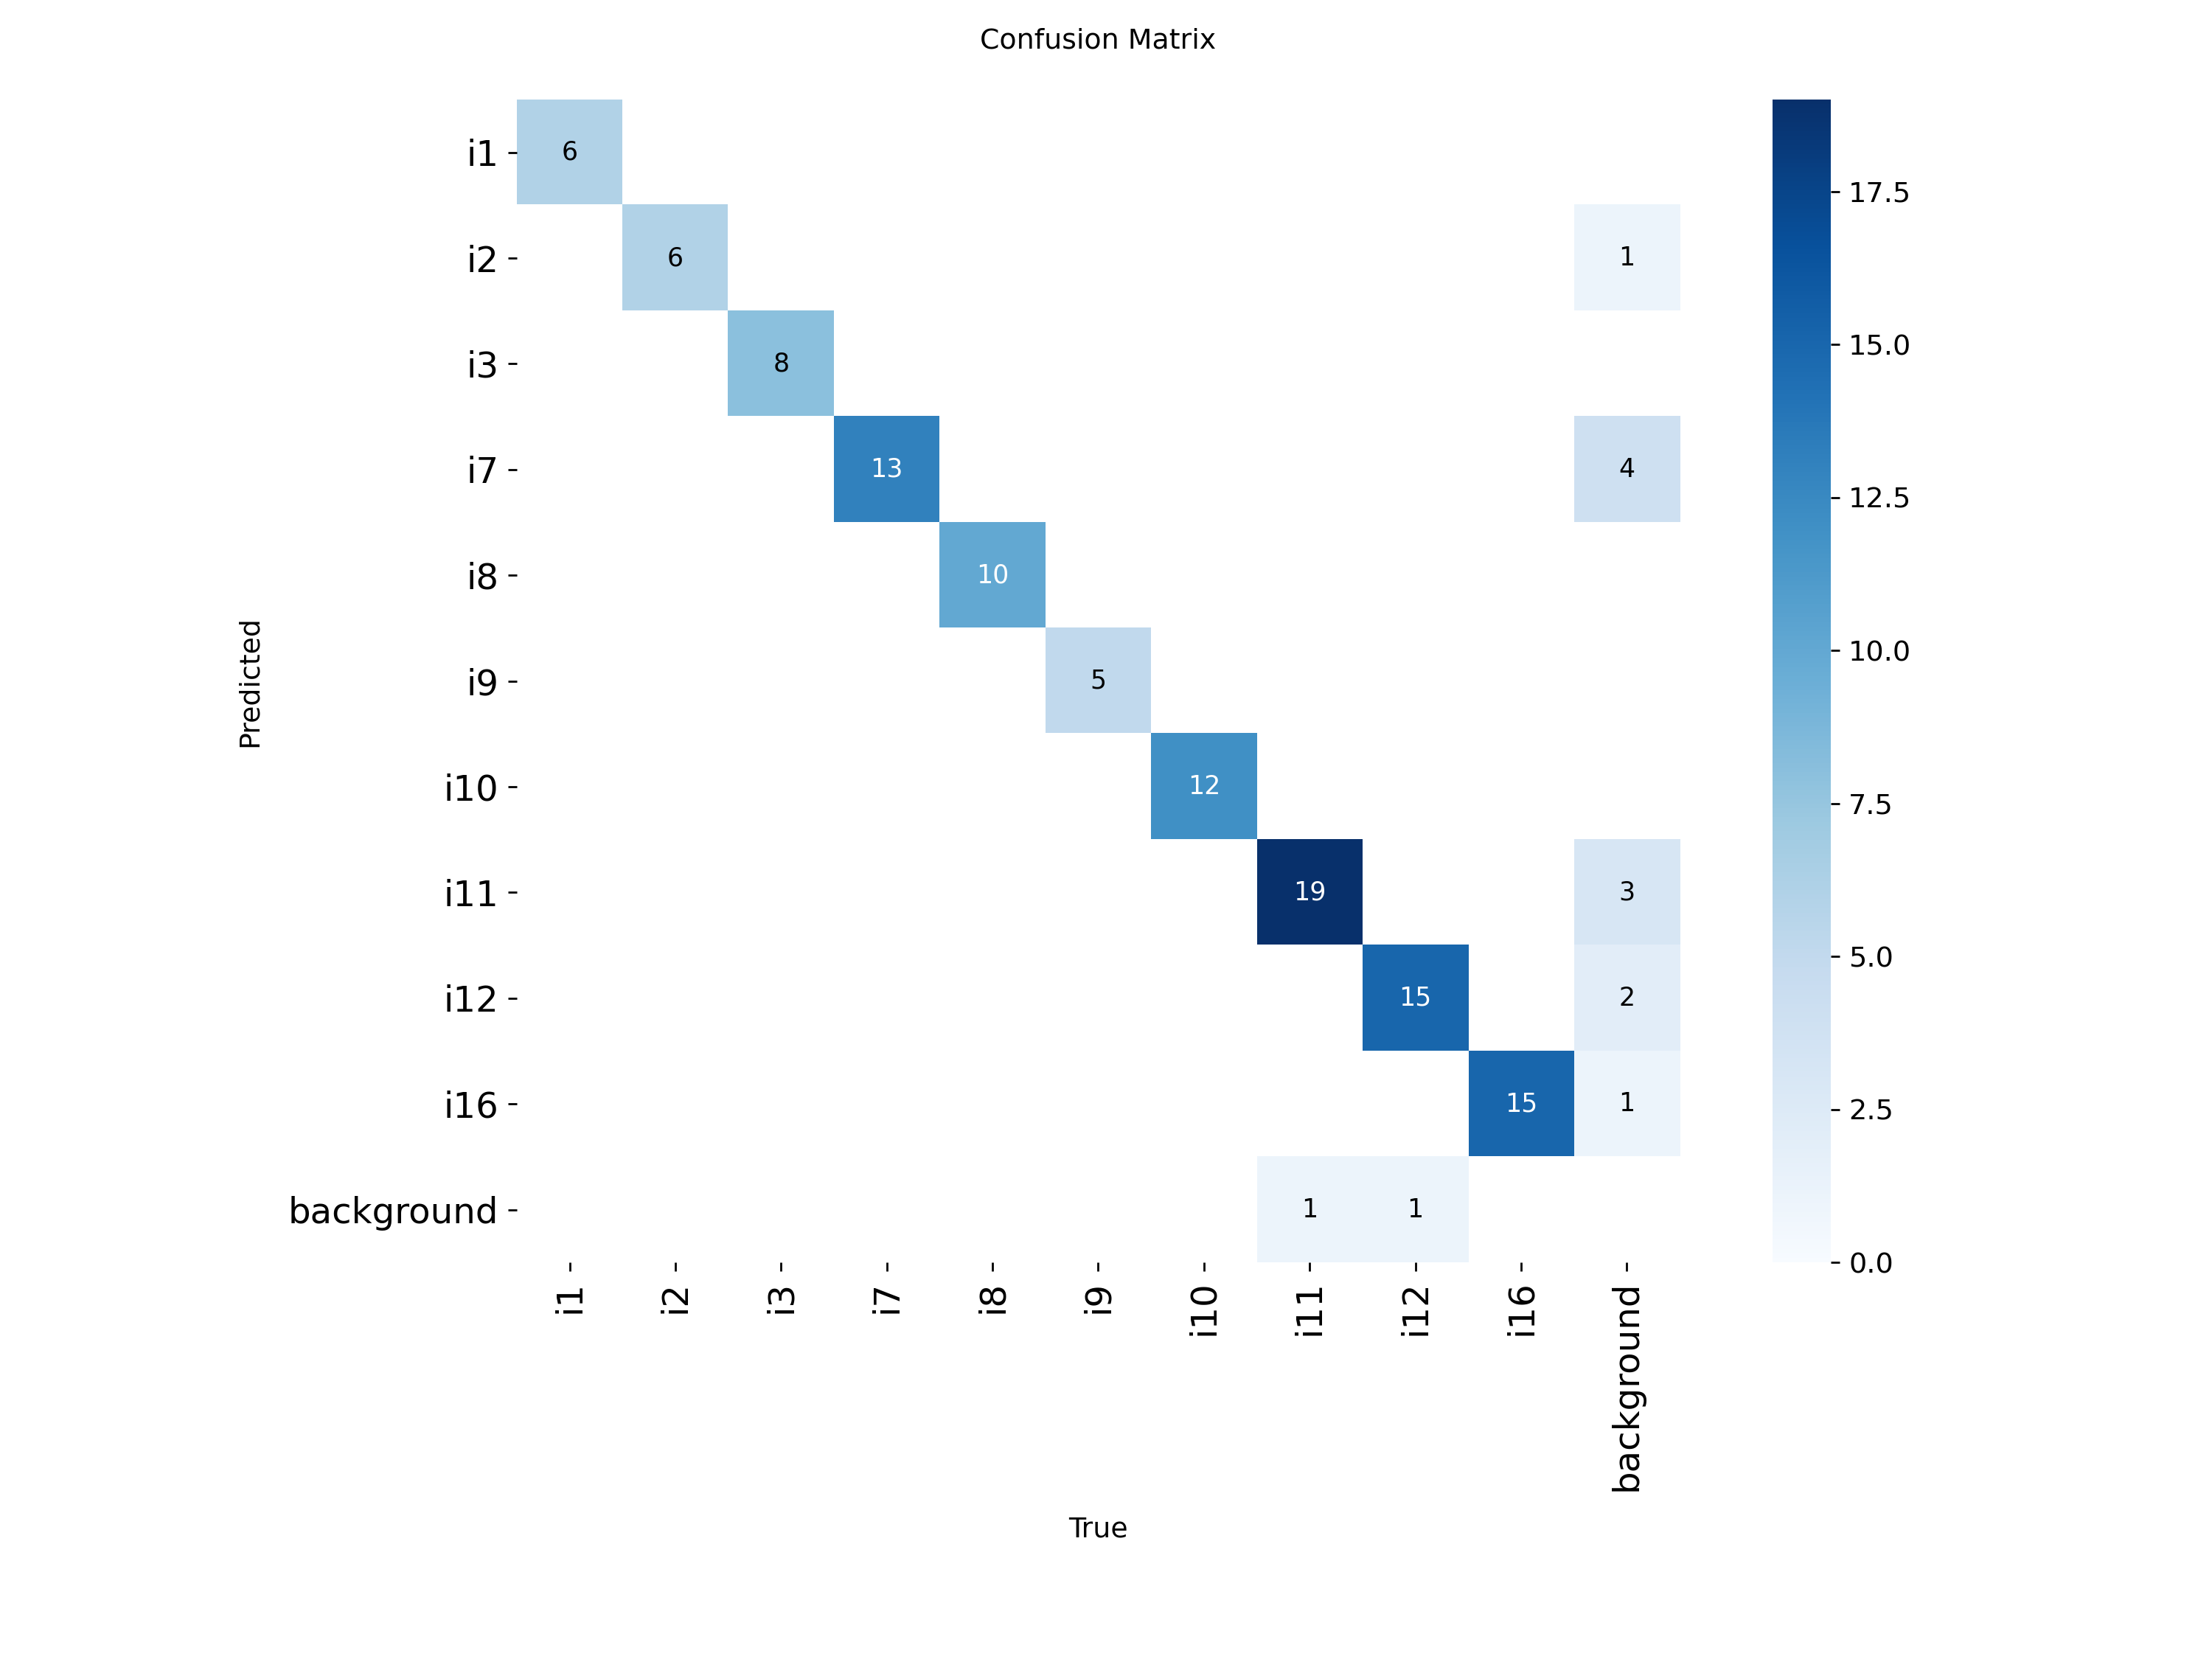

In [ ]:
Image(filename=f"{HOME}/runs/detect/train5/confusion_matrix.png", width=IMAGE_WIDTH, height=IMAGE_HEIGHT)

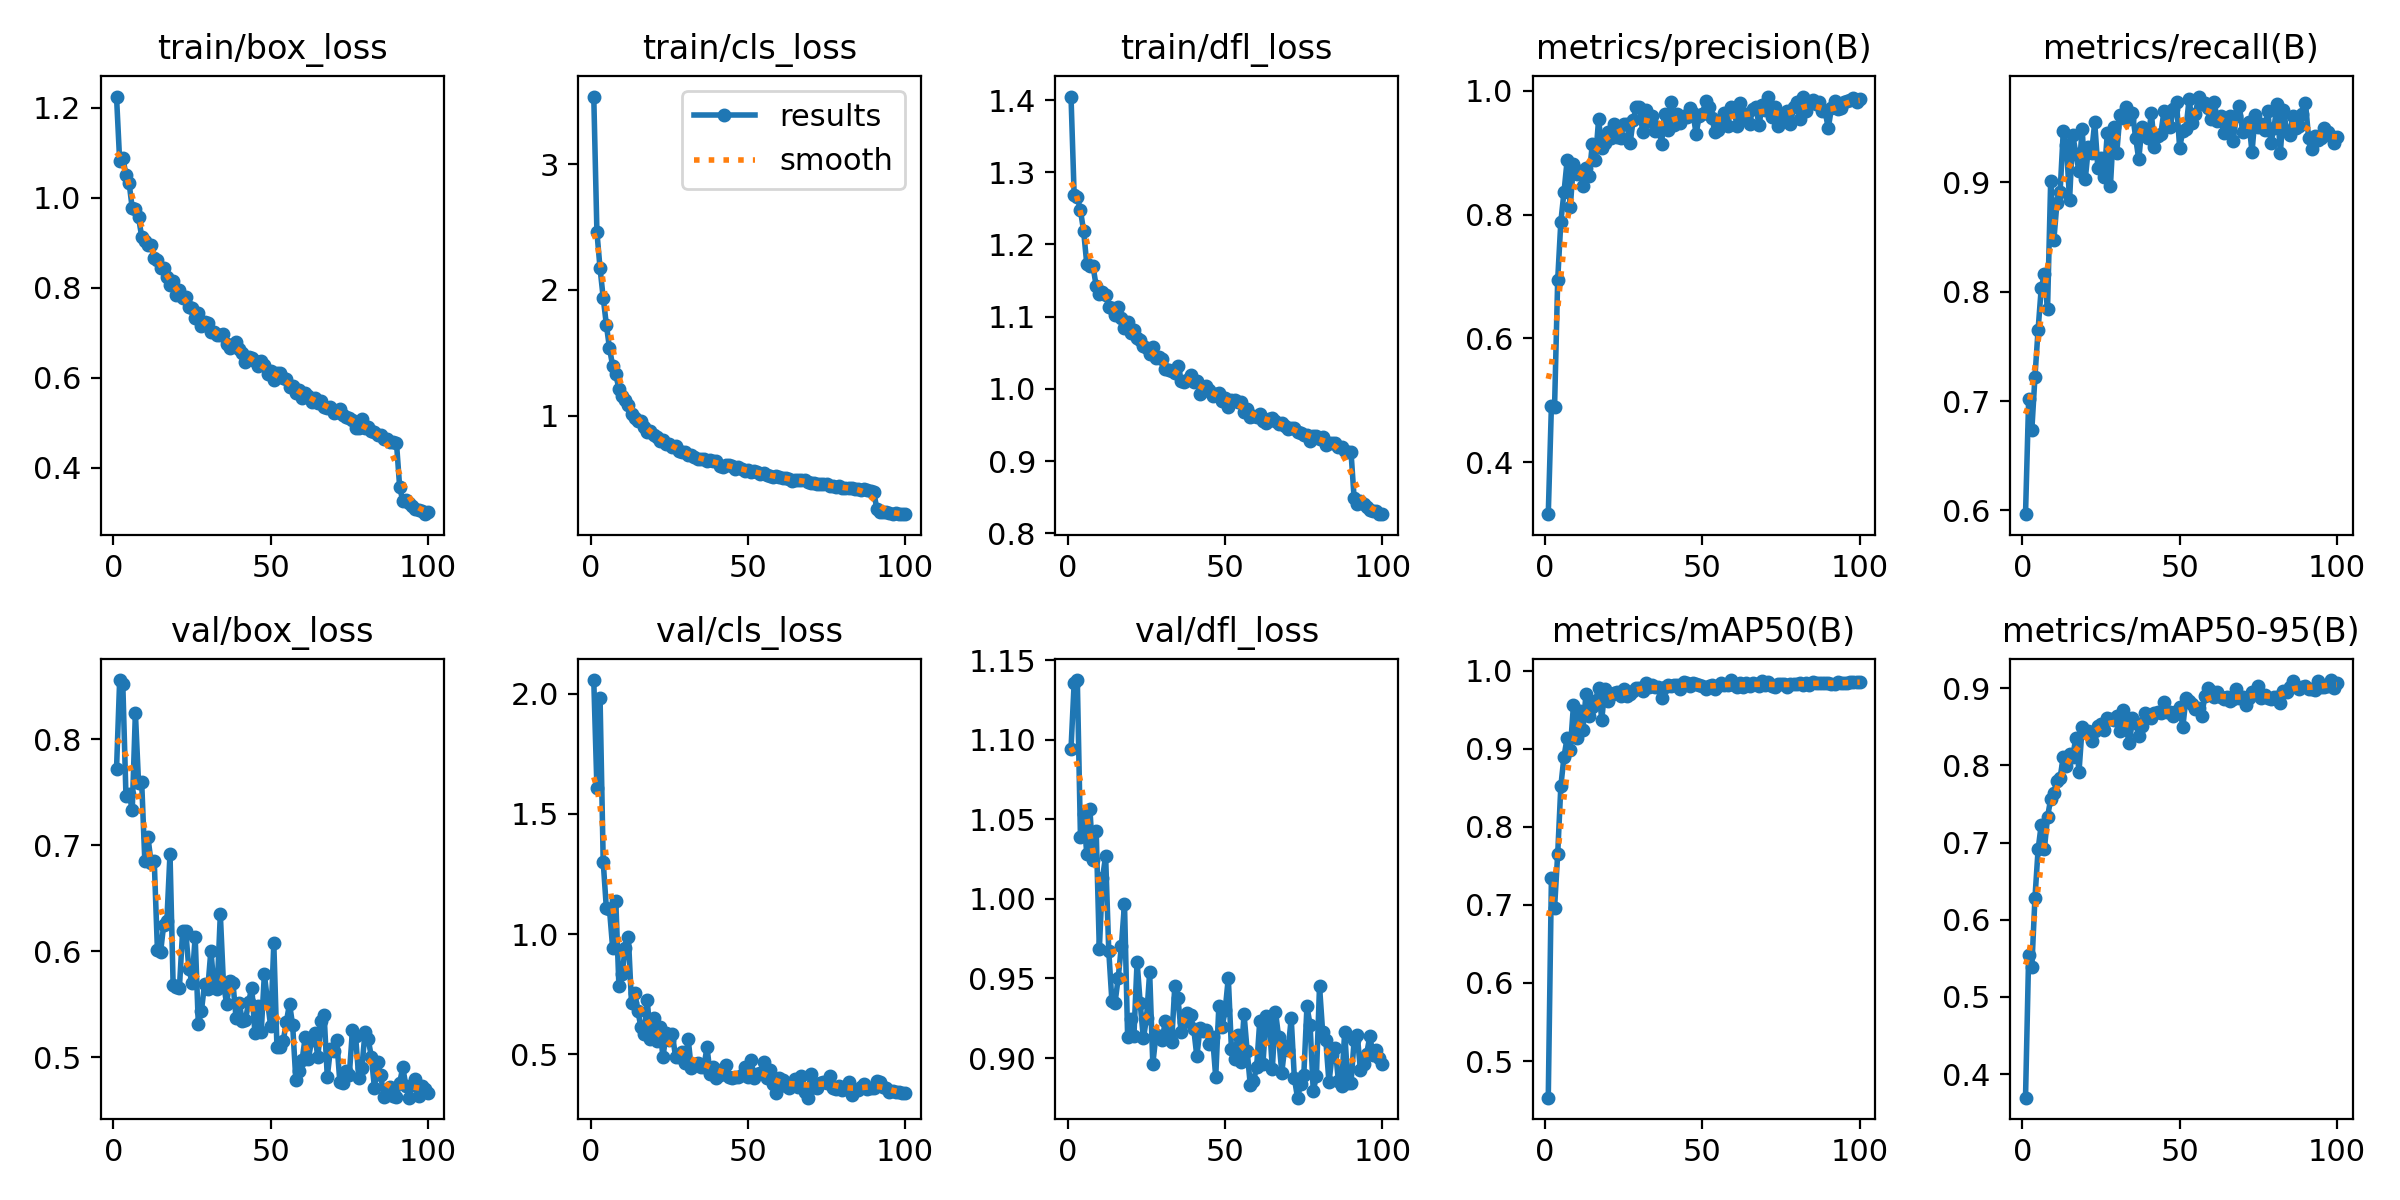

In [ ]:
Image(filename=f"{HOME}/runs/detect/train5/results.png", width=IMAGE_WIDTH)

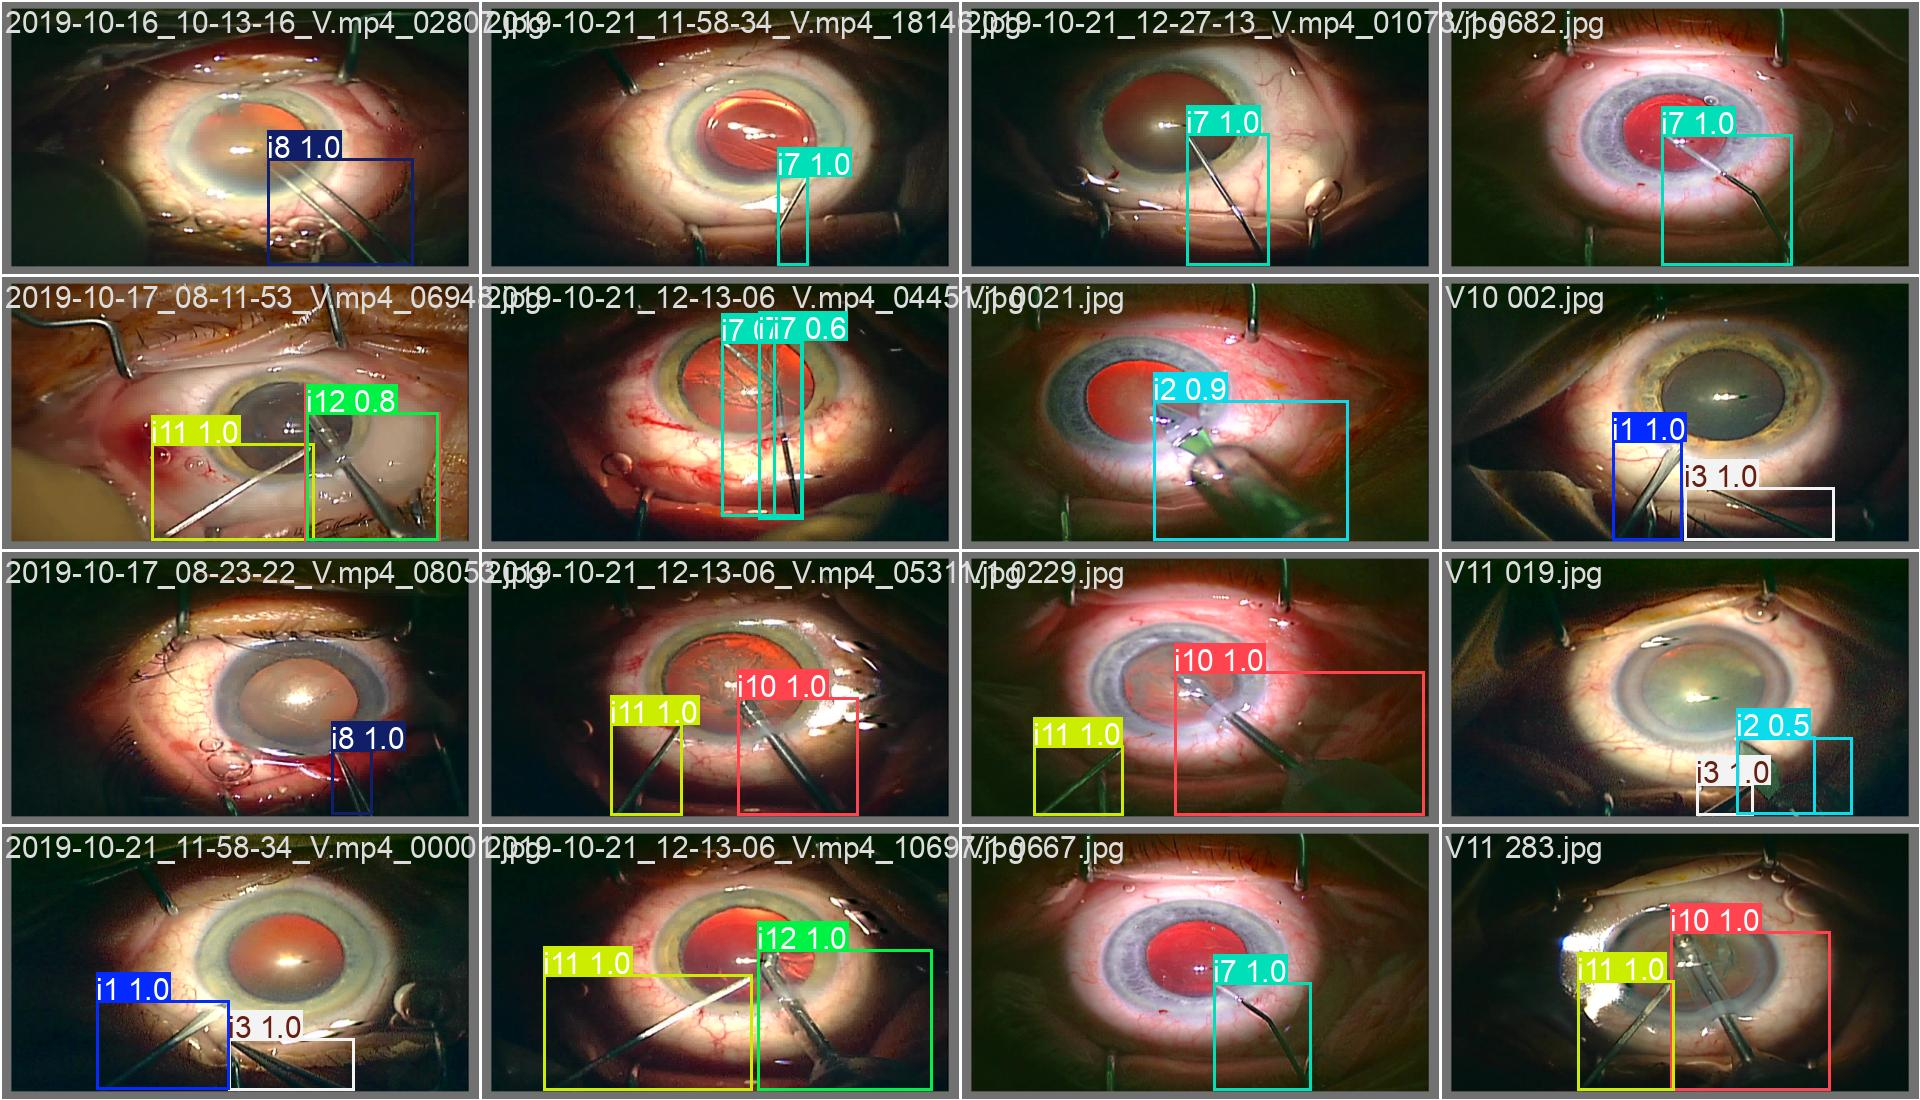

In [ ]:
Image(filename=f"{HOME}/runs/detect/train5/val_batch0_pred.jpg", width=IMAGE_WIDTH, height=IMAGE_HEIGHT)

### Validate Custom Model

In [ ]:
!yolo task=detect mode=val \
    data=/content/cataract_dataset_segmentation/data.yaml \
    model=/content/runs/detect/train5/weights/best.pt \
    imgsz=640

Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1465.1±842.3 MB/s, size: 56.4 KB)
val: Scanning /content/cataract_dataset_segmentation/labels/val.cache... 84 images, 0 backgrounds, 0 corrupt: 100% 84/84 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:01<00:00,  3.81it/s]
                   all         84        111      0.988      0.942      0.986      0.903
                    i1          6          6      0.953          1      0.995      0.974
                    i2          6          6      0.988          1      0.995      0.852
                    i3          8          8      0.994          1      0.995      0.867
                    i7         13         13          1      0.727      0.979      0.885
                    i8         10         10  

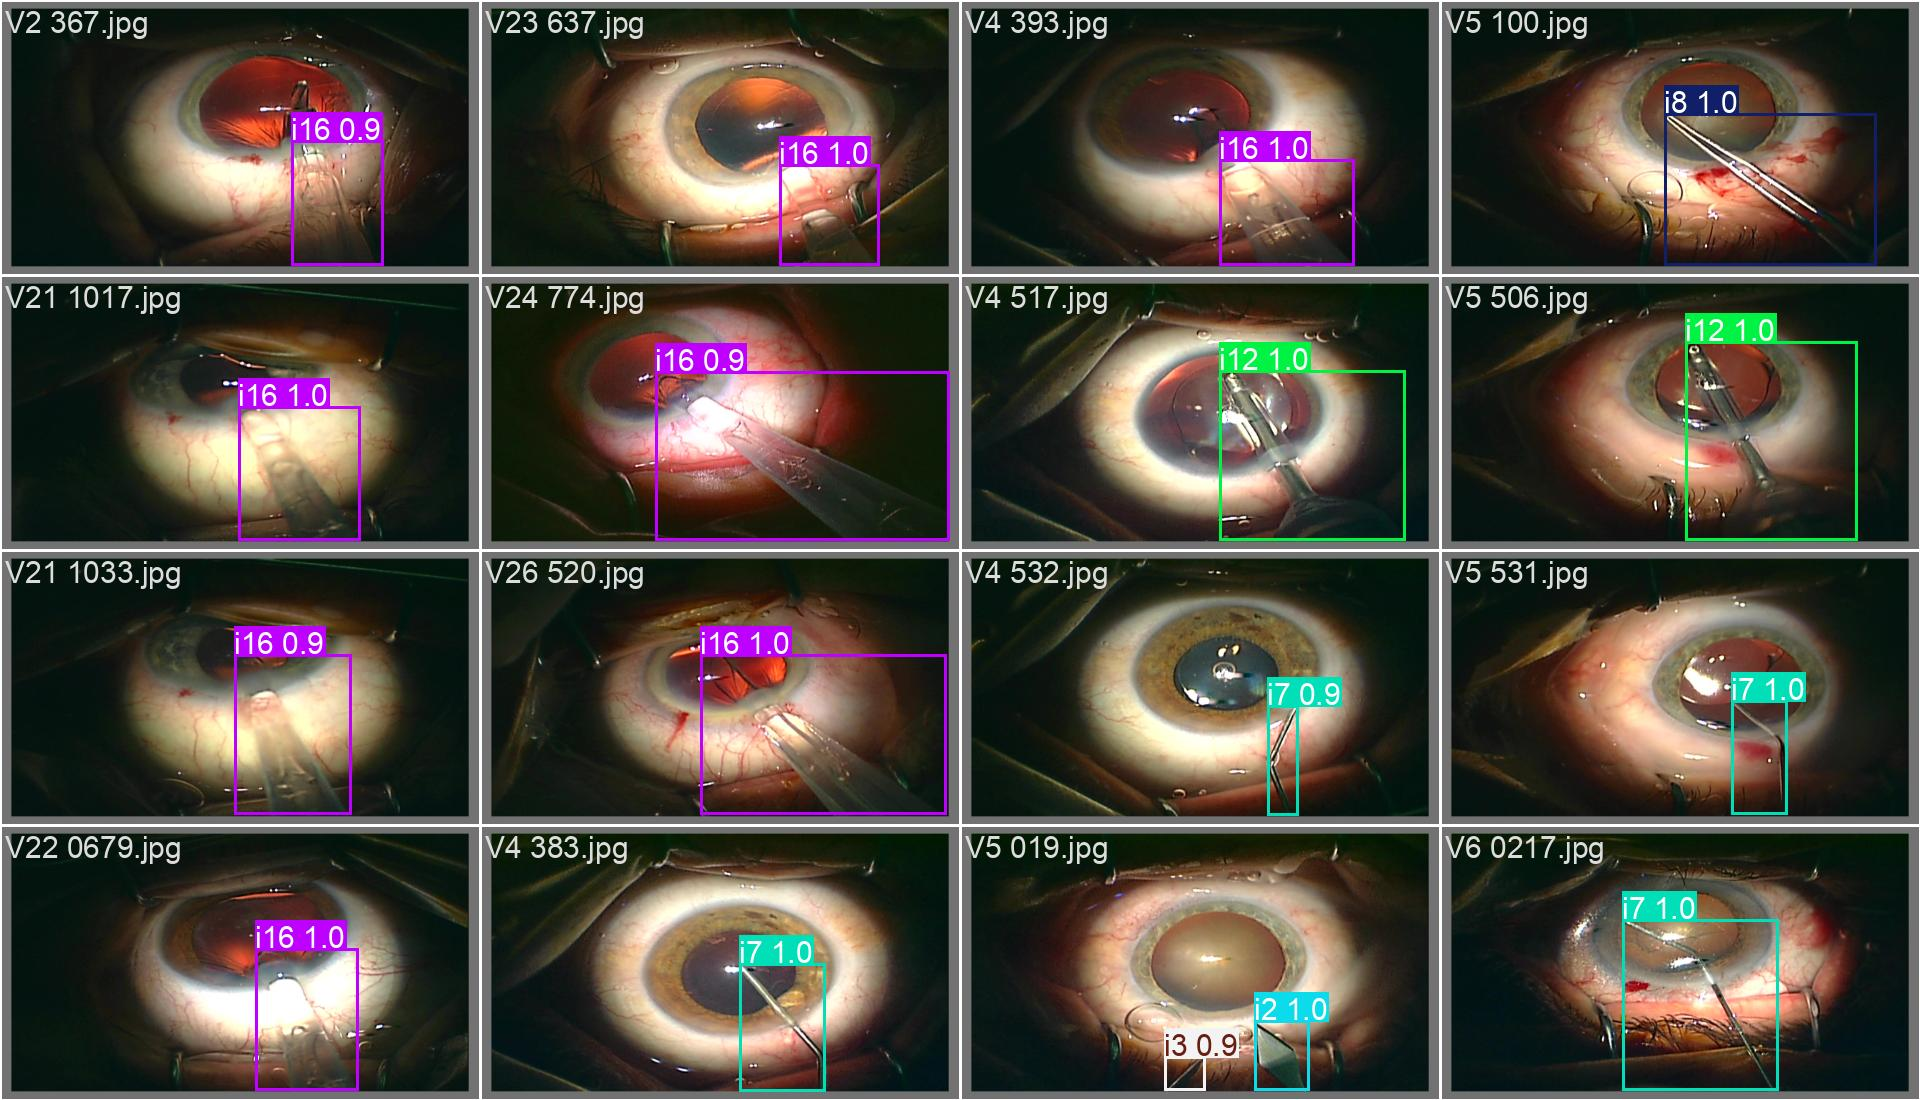

In [ ]:
Image(filename=f"{HOME}/runs/detect/val3/val_batch2_pred.jpg", width=IMAGE_WIDTH, height=IMAGE_HEIGHT)

### Inference with Custom Model

In [ ]:
!yolo task=detect mode=predict \
    model=runs/detect/train5/weights/best.pt \
    source=/content/cataract_dataset_segmentation/images/test \
    imgsz=640 \
    conf=0.25 \
    save=True

Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs

image 1/85 /content/cataract_dataset_segmentation/images/test/2019-10-16_10-13-16_V.mp4_02467.jpg: 384x640 1 i8, 59.8ms
image 2/85 /content/cataract_dataset_segmentation/images/test/2019-10-16_11-07-49_V.mp4_04000.jpg: 384x640 1 i8, 13.4ms
image 3/85 /content/cataract_dataset_segmentation/images/test/2019-10-17_08-11-53_V.mp4_00205.jpg: 384x640 1 i2, 9.3ms
image 4/85 /content/cataract_dataset_segmentation/images/test/2019-10-17_08-11-53_V.mp4_13542.jpg: 384x640 1 i12, 8.0ms
image 5/85 /content/cataract_dataset_segmentation/images/test/2019-10-17_08-23-22_V.mp4_11678.jpg: 384x640 1 i10, 1 i11, 10.9ms
image 6/85 /content/cataract_dataset_segmentation/images/test/2019-10-21_11-58-34_V.mp4_00086.jpg: 384x640 1 i1, 1 i3, 8.5ms
image 7/85 /content/cataract_dataset_segmentation/images/test/2019-10-21_11-58-34_V.mp4_01337.jpg: 384x6

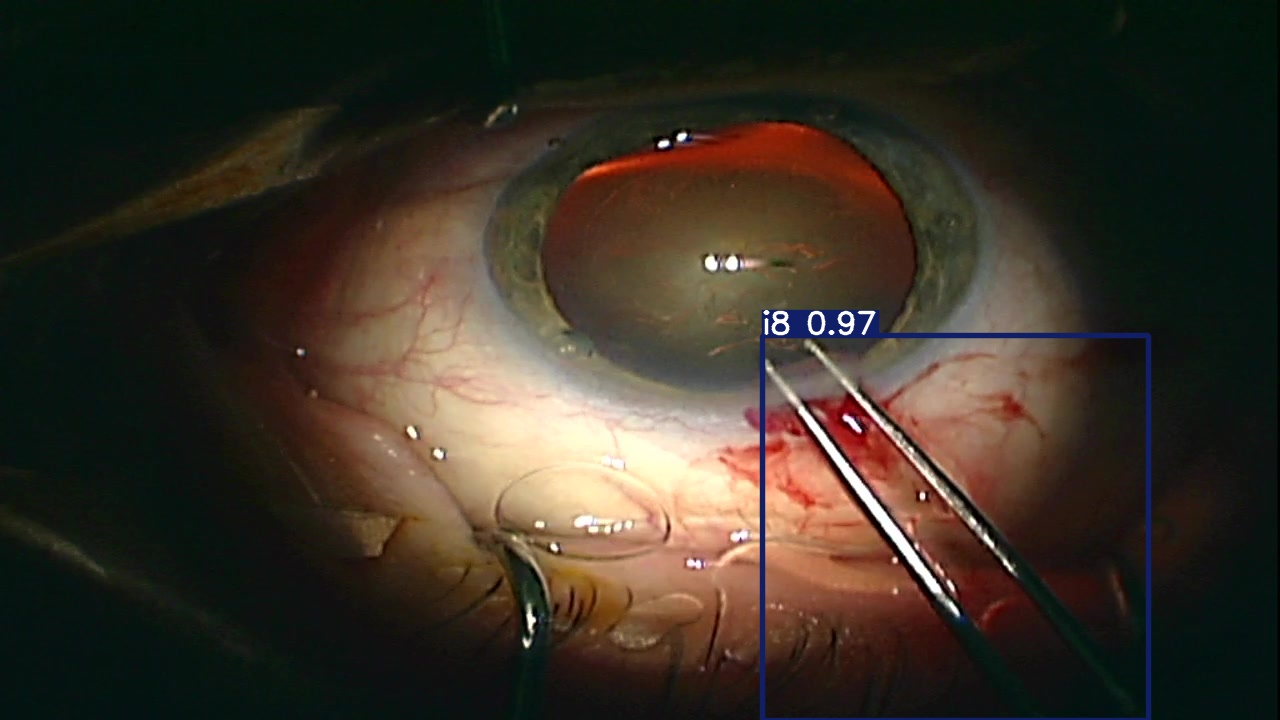

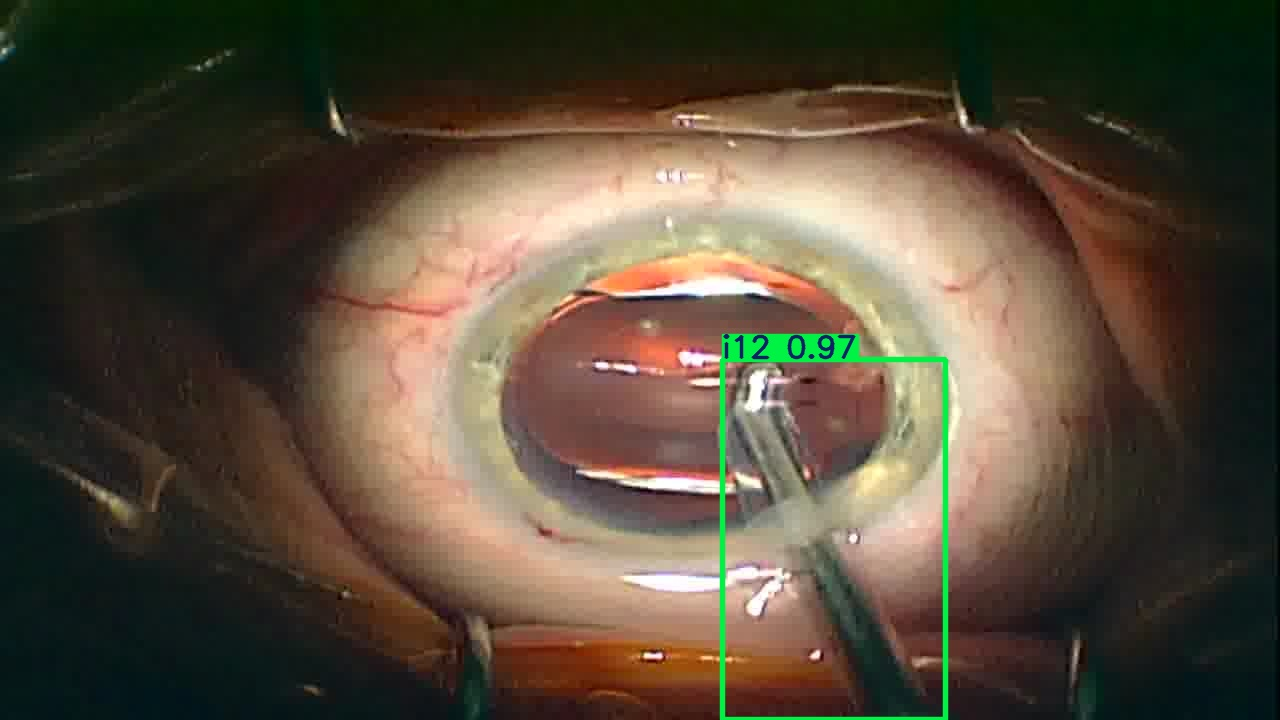

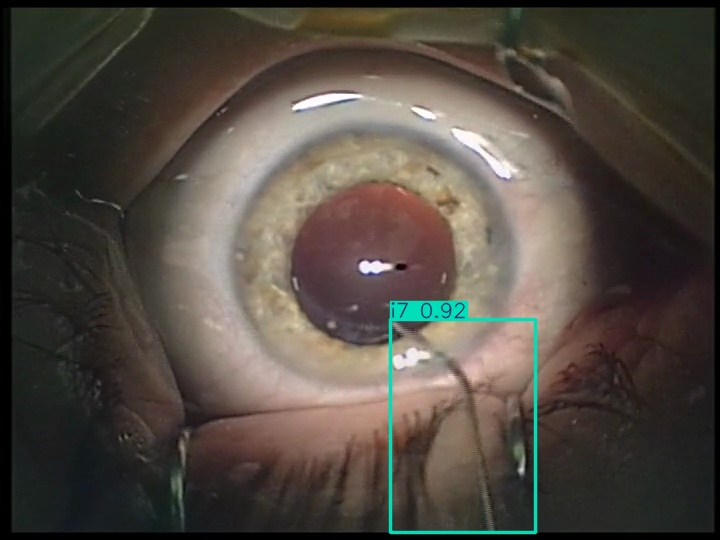

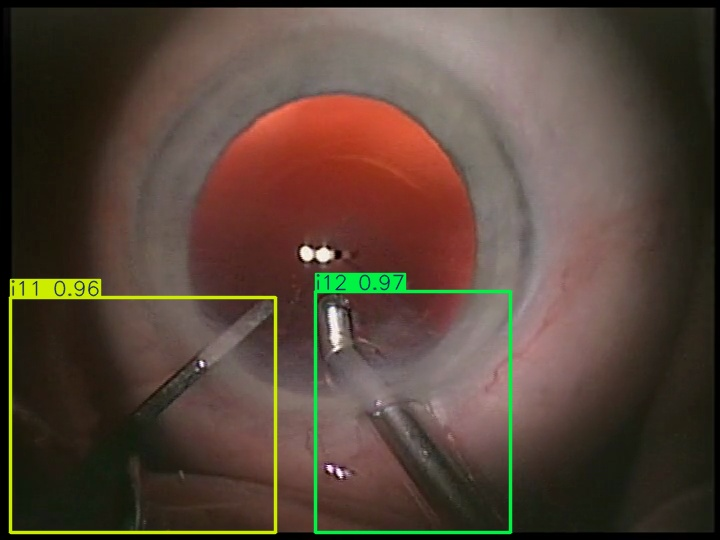

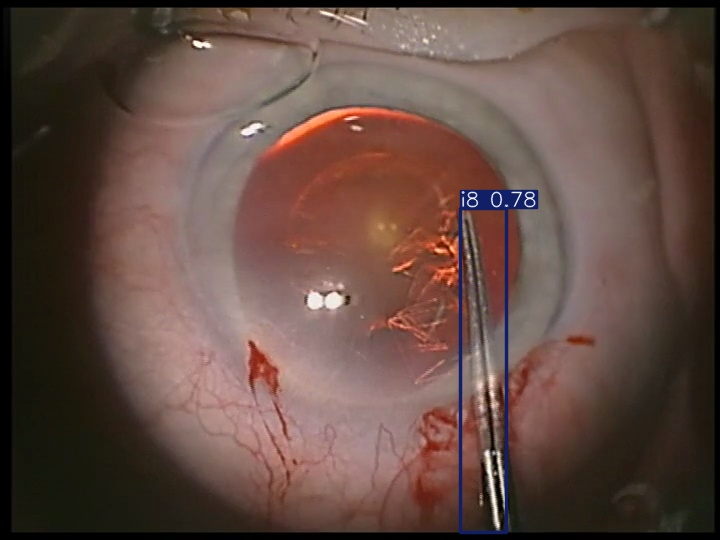

In [ ]:
base_path = '/content/runs/detect/'

subfolders = [os.path.join(base_path, d) for d in os.listdir(base_path)
              if os.path.isdir(os.path.join(base_path, d)) and d.startswith('predict3')]

latest_folder = max(subfolders, key=os.path.getmtime)

image_paths = glob.glob(f'{latest_folder}/*.jpg')[:5]

for image_path in image_paths:
    display(Image(filename=image_path, width=640))
    print("\n")

## Comapre models

In [65]:
import pandas as pd
from pathlib import Path

# List your YOLO run directories
model_dirs = [
    Path("runs/detect/train"),   # Model 1
    Path("runs/detect/train4"),  # Model 2
    Path("runs/detect/train5")   # Model 3
]

# Try possible column names for metrics (depends on YOLOv8 version)
metric_map = {
    "precision": ["precision", "metrics/precision(B)"],
    "recall": ["recall", "metrics/recall(B)"],
    "map50": ["map50", "metrics/mAP50(B)"],
    "map": ["map", "metrics/mAP50-95(B)"]
}

def find_column(df, candidates):
    """Return the first matching column name from candidates."""
    for col in candidates:
        if col in df.columns:
            return col
    raise KeyError(f"No matching column found in {df.columns} for {candidates}")

results = {}
for i, dir_path in enumerate(model_dirs, start=1):
    csv_path = dir_path / "results.csv"
    if not csv_path.exists():
        print(f"No results.csv found in {dir_path}, skipping.")
        continue

    df = pd.read_csv(csv_path)
    final_row = df.iloc[-1]  # last epoch

    results[f"Model {i}"] = {
        "precision": final_row[find_column(df, metric_map["precision"])],
        "recall": final_row[find_column(df, metric_map["recall"])],
        "map50": final_row[find_column(df, metric_map["map50"])],
        "map": final_row[find_column(df, metric_map["map"])],
    }

# Create DataFrame
results_df = pd.DataFrame(results).T.round(3)
print("\n=== YOLOv8 Model Comparison ===")
print(results_df)

# Show best per metric
print("\nBest model per metric:")
for metric in ["precision", "recall", "map50", "map"]:
    best_model = results_df[metric].idxmax()
    print(f"{metric:<10}: {best_model} ({results_df[metric].max():.3f})")

# Save
results_df.to_csv("yolo_model_comparison.csv")
print("\nSaved to yolo_model_comparison.csv")


=== YOLOv8 Model Comparison ===
         precision  recall  map50    map
Model 1      0.941   0.953  0.977  0.879
Model 2      0.939   0.924  0.967  0.877
Model 3      0.987   0.942  0.986  0.907

Best model per metric:
precision : Model 3 (0.987)
recall    : Model 1 (0.953)
map50     : Model 3 (0.986)
map       : Model 3 (0.907)

Saved to yolo_model_comparison.csv
